# Air Quality in NYC


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
#from google.colab import files, drive
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Import All Datasets

In [ ]:
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import the Air Quality Dataset

#file_path = "/content/drive/MyDrive/Intro to DS Final Project/Air_Quality_20251112.csv"
#file_path = "/home/sag349/mine/data/Air_Quality_20251112.csv" IF PATH BELOW DOESN'T WORK USE CODEBENCH PATHS
file_path = "./data/Air_Quality_20251112.csv"

chunksize = 10000
chunks = []

for chunk in pd.read_csv(file_path, chunksize = chunksize):
  chunks.append(chunk)

df_air_quality = pd.concat(chunks)
df_air_quality.head()

Unique ID  Indicator ID        Name Measure Measure Info Geo Type Name  \
0     878169           386  Ozone (O3)    Mean          ppb            CD   
1     878131           386  Ozone (O3)    Mean          ppb            CD   
2     878117           386  Ozone (O3)    Mean          ppb            CD   
3     878167           386  Ozone (O3)    Mean          ppb            CD   
4     878151           386  Ozone (O3)    Mean          ppb            CD   

   Geo Join ID                         Geo Place Name  Time Period  \
0          102       Greenwich Village and Soho (CD2)  Summer 2023   
1          401     Long Island City and Astoria (CD1)  Summer 2023   
2          305  East New York and Starrett City (CD5)  Summer 2023   
3          104              Clinton and Chelsea (CD4)  Summer 2023   
4          208          Riverdale and Fieldston (CD8)  Summer 2023   

   Start_Date  Data Value  Message  
0  06/01/2023   28.979053      NaN  
1  06/01/2023   33.558581      NaN  
2  06/01/2023   36.560987      NaN  
3  06/01/2023   28.471028      NaN  
4  06/01/2023   29.626745      NaN

In [ ]:
# We used an API to pull this data from the application
from flask import Flask, jsonify, send_file
import requests
import csv
import os

app = Flask(__name__)

SERVICE_URL = "https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/ArcGIS/rest/services/ComDistData01_July2024Update1/FeatureServer/0/query"

def fetch_all_cds(csv_filename="nyc_cd_population.csv"):
    """Fetch all community districts and save CSV in current folder."""
    params = {
        "where": "1=1",
        "outFields": "BoroCD,Borough,CDName,Pop_20",
        "f": "json"
    }
    r = requests.get(SERVICE_URL, params=params)
    data = r.json()
    features = data.get("features", [])

    all_cds = []
    for f in features:
        attrs = f["attributes"]
        all_cds.append({
            "CDName": attrs.get("CDName"),
            "Borough": attrs.get("Borough"),
            "CD": attrs.get("BoroCD"),
            "Population_2020": attrs.get("Pop_20"),
            "Year": 2020  # Added year field
        })

    # Save CSV in the same folder as app.py
    csv_path = os.path.join(os.path.dirname(__file__), csv_filename)
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["CDName","Borough","CD","Population_2020","Year"])
        writer.writeheader()
        for row in all_cds:
            writer.writerow(row)

    return all_cds, csv_path

@app.get("/all_population")
def all_population():
    """Return JSON with all CDs and save CSV."""
    cds, csv_path = fetch_all_cds()
    return jsonify({
        "message": f"Successfully fetched {len(cds)} CDs",
        "csv_file": csv_path,
        "data": cds
    })

@app.get("/download_population_csv")
def download_csv():
    """Download CSV directly from browser."""
    csv_path = os.path.join(os.path.dirname(__file__), "nyc_cd_population.csv")
    if not os.path.exists(csv_path):
        fetch_all_cds()  # regenerate CSV if it doesn’t exist
    return send_file(csv_path, as_attachment=True)

if __name__ == "__main__":
    app.run(debug=True)

In [ ]:
# Import the NYC Population by Neighborhood Dataset

file_path = "/content/drive/MyDrive/Intro to DS Final Project/air_quality_api/nyc_cd_population.csv"

chunksize = 10000
chunks = []

for chunk in pd.read_csv(file_path, chunksize = chunksize):
  chunks.append(chunk)

df_population_neighborhood = pd.concat(chunks)
df_population_neighborhood.head()

CD    Borough                          CDName  Population_2020
0  308   Brooklyn   Brooklyn Community District 8           108259
1  205      Bronx      Bronx Community District 5           132584
2  311   Brooklyn  Brooklyn Community District 11           198870
3  410     Queens    Queens Community District 10           129411
4  164  Manhattan                    Central Park              129

In [ ]:
# Import the NYC Parks Properties

file_path = "/content/drive/MyDrive/Intro to DS Final Project/Parks_Properties_20251112.csv"

chunksize = 10000
chunks = []

for chunk in pd.read_csv(file_path, chunksize = chunksize):
  chunks.append(chunk)

df_parks = pd.concat(chunks)
df_parks.head()

ACQUISITIONDATE  ACRES                ADDRESS BOROUGH CLASS  \
0                      NaN  0.356   200-15 MCLAUGHLIN AV       Q  PARK   
1  1973 Dec 30 12:00:00 AM   0.67       750-802 RIVER AV       X  PARK   
2  1948 Aug 19 12:00:00 AM  0.211           741 1 AVENUE       M  PARK   
3  1938 Apr 19 12:00:00 AM  1.837  88-02 ATLANTIC AVENUE       Q  PARK   
4  1888 Apr 24 12:00:00 AM   1.24      1501 AMSTERDAM Av       M  PARK   

  COMMUNITYBOARD COUNCILDISTRICT DEPARTMENT                       EAPPLY  \
0            408              23       Q-08        McLaughlin Playground   
1            204              16       X-04           River Avenue Parks   
2            106               4       M-06            Ralph Bunche Park   
3            409              32       Q-09  London Planetree Playground   
4            109               7       M-09            Annunciation Park   

      GISOBJID  ... PIP_RATABLE PRECINCT RETIRED                     SIGNNAME  \
0  100,000,044  ...        True    107.0   False        McLaughlin Playground   
1  100,004,862  ...       False     44.0   False           River Avenue Parks   
2  100,004,411  ...        True     17.0   False            Ralph Bunche Park   
3  100,000,165  ...        True    102.0   False  London Planetree Playground   
4  100,003,894  ...        True     26.0   False      Annunciation Playground   

                  SUBCATEGORY       TYPECATEGORY US_CONGRESS WATERFRONT  \
0           Neighborhood Plgd         Playground           5      False   
1           Neighborhood Plgd         Playground          15      False   
2  Sitting Area/Triangle/Mall     Triangle/Plaza          12      False   
3           Neighborhood Plgd  Neighborhood Park           7      False   
4           Neighborhood Plgd         Playground          13      False   

  ZIPCODE                                       multipolygon  
0   11423  MULTIPOLYGON (((-73.76596231448613 40.72551186...  
1   10451  MULTIPOLYGON (((-73.92706900971802 40.82485894...  
2   10017  MULTIPOLYGON (((-73.96998665551673 40.74904361...  
3   11416  MULTIPOLYGON (((-73.85277880723194 40.68568340...  
4   10031  MULTIPOLYGON (((-73.9519755363393 40.817825274...  

[5 rows x 34 columns]

## Data Pre-Processing

### Air Quality Dataset Pre-Processing

**https://data.cityofnewyork.us/Environment/Air-Quality/c3uy-2p5r/about_data**

Columns:
*   Unique ID
*   Indicator ID
*   Name (of Indicator)
    1.  Indicator ID: 386 = Name: Ozone (O3)
    2.  Indicator ID: 365 = Name: Fine particles (PM 2.5)
    3.  Indicator ID: 375 = Name: Nitrogen dioxide (NO2)
*   Measure (how indicator is measured)
*   Measure Info (units)
*   Geo Type Name (Borough, Community Districts, UHF, Citywide)
*   Geo Join ID (Identifier of Geographic Area)
*   Geo Place Name
*   Time Period (year, range, season): All Summer 2023 or annual
*   Start Date (of time period): All 6/1/2023
*   Data Value (actual value of air quality)
*   Message (notes)

Borough Geo Join ID:
* 1 → Manhattan
* 2 → Bronx
* 3 → Brooklyn
* 4 → Queens
* 5 → Staten Island


Measure vs Indicator:
*  Number per km2 → boiler emissions
*  Estimated annual rate → asthma hospitalizations
* Million miles → Annual vehicle miles traveled
* Mean → Everything else










In [ ]:
df1 = df_air_quality
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18862 entries, 0 to 18861
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unique ID       18862 non-null  int64  
 1   Indicator ID    18862 non-null  int64  
 2   Name            18862 non-null  object 
 3   Measure         18862 non-null  object 
 4   Measure Info    18862 non-null  object 
 5   Geo Type Name   18862 non-null  object 
 6   Geo Join ID     18862 non-null  int64  
 7   Geo Place Name  18862 non-null  object 
 8   Time Period     18862 non-null  object 
 9   Start_Date      18862 non-null  object 
 10  Data Value      18862 non-null  float64
 11  Message         0 non-null      float64
dtypes: float64(2), int64(3), object(7)
memory usage: 1.7+ MB
None


In [ ]:
# Drop Unncessary Columns: Message, Time Period, Start Date, Unique ID
df1 = df1.drop(columns = ['Message', 'Time Period', 'Start_Date', 'Unique ID', 'Indicator ID'])
df1 = df1.dropna()
df1 = df1.drop_duplicates()
df1 = df1.rename(columns = {'Name': 'Name_Indicator'})

In [ ]:
# Get counts of columns with different variations
for col in df1.columns:
  print(df1[col].value_counts(), '\n\n')

Name_Indicator
Nitrogen dioxide (NO2)                                    6306
Fine particles (PM 2.5)                                   6232
Ozone (O3)                                                2097
Asthma emergency department visits due to PM2.5            479
Asthma emergency departments visits due to Ozone           474
Asthma hospitalizations due to Ozone                       464
Annual vehicle miles traveled                              321
Annual vehicle miles traveled (trucks)                     321
Annual vehicle miles traveled (cars)                       321
Deaths due to PM2.5                                        240
Respiratory hospitalizations due to PM2.5 (age 20+)        240
Cardiovascular hospitalizations due to PM2.5 (age 40+)     238
Cardiac and respiratory deaths due to Ozone                206
Outdoor Air Toxics - Benzene                               203
Outdoor Air Toxics - Formaldehyde                          203
Boiler Emissions- Total SO2 Emissions   

In [ ]:
# Filter datasets based on 3 types of major air pollutant indicator

ozone_indicators = [
    "Ozone (O3)",
    "Asthma emergency departments visits due to Ozone",
    "Asthma hospitalizations due to Ozone",
    "Cardiac and respiratory deaths due to Ozone"
]
df_o3 = df1[df1['Name_Indicator'].isin(ozone_indicators)].copy()
print('Ozone (O3): \n', df_o3.head(), '\n\n')

pm25_indicators = [
    "Fine particles (PM 2.5)",
    "Asthma emergency department visits due to PM2.5",
    "Deaths due to PM2.5",
    "Respiratory hospitalizations due to PM2.5 (age 20+)",
    "Cardiovascular hospitalizations due to PM2.5 (age 40+)"
]
df_pm25 = df1[df1['Name_Indicator'].isin(pm25_indicators)].copy()
print('Fine particles (PM 2.5): \n', df_pm25.head(), '\n\n')

no2_indicators = [
    "Nitrogen dioxide (NO2)"
]
df_no2 = df1[df1['Name_Indicator'].isin(no2_indicators)].copy()
print('Nitrogen dioxide (NO2): \n', df_no2.head(), '\n\n')

distance_indicators = [
    "Annual vehicle miles traveled",
    "Annual vehicle miles traveled (cars)",
    "Annual vehicle miles traveled (trucks)"
]
df_distance = df1[df1['Name_Indicator'].isin(distance_indicators)].copy()
print('Annual vehicle miles traveled: \n', df_distance.head(), '\n\n')

Ozone (O3): 
   Name_Indicator Measure Measure Info Geo Type Name  Geo Join ID  \
0     Ozone (O3)    Mean          ppb            CD          102   
1     Ozone (O3)    Mean          ppb            CD          401   
2     Ozone (O3)    Mean          ppb            CD          305   
3     Ozone (O3)    Mean          ppb            CD          104   
4     Ozone (O3)    Mean          ppb            CD          208   

                          Geo Place Name  Data Value  
0       Greenwich Village and Soho (CD2)   28.979053  
1     Long Island City and Astoria (CD1)   33.558581  
2  East New York and Starrett City (CD5)   36.560987  
3              Clinton and Chelsea (CD4)   28.471028  
4          Riverdale and Fieldston (CD8)   29.626745   


Fine particles (PM 2.5): 
              Name_Indicator Measure Measure Info Geo Type Name  Geo Join ID  \
10  Fine particles (PM 2.5)    Mean       mcg/m3         UHF42          304   
19  Fine particles (PM 2.5)    Mean       mcg/m3         UH

### Population Dataset Pre-Processing

In [ ]:
df2 = df_population_neighborhood
df2.head()

CD    Borough                          CDName  Population_2020
0  308   Brooklyn   Brooklyn Community District 8           108259
1  205      Bronx      Bronx Community District 5           132584
2  311   Brooklyn  Brooklyn Community District 11           198870
3  410     Queens    Queens Community District 10           129411
4  164  Manhattan                    Central Park              129

In [ ]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CD               71 non-null     int64 
 1   Borough          71 non-null     object
 2   CDName           71 non-null     object
 3   Population_2020  71 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 2.3+ KB
None


In [ ]:
# Drop Unncessary Columns: CD, CDName
df2 = df2.drop(columns = ['CD', 'CDName'])
df2 = df2.dropna()
df2 = df2.drop_duplicates()
df2["Population_2020"] = pd.to_numeric(df2["Population_2020"])

### Park Dataset Pre-Processing

In [ ]:
df3 = df_parks
df3.head()

ACQUISITIONDATE  ACRES                ADDRESS BOROUGH CLASS  \
0                      NaN  0.356   200-15 MCLAUGHLIN AV       Q  PARK   
1  1973 Dec 30 12:00:00 AM   0.67       750-802 RIVER AV       X  PARK   
2  1948 Aug 19 12:00:00 AM  0.211           741 1 AVENUE       M  PARK   
3  1938 Apr 19 12:00:00 AM  1.837  88-02 ATLANTIC AVENUE       Q  PARK   
4  1888 Apr 24 12:00:00 AM   1.24      1501 AMSTERDAM Av       M  PARK   

  COMMUNITYBOARD COUNCILDISTRICT DEPARTMENT                       EAPPLY  \
0            408              23       Q-08        McLaughlin Playground   
1            204              16       X-04           River Avenue Parks   
2            106               4       M-06            Ralph Bunche Park   
3            409              32       Q-09  London Planetree Playground   
4            109               7       M-09            Annunciation Park   

      GISOBJID  ... PIP_RATABLE PRECINCT RETIRED                     SIGNNAME  \
0  100,000,044  ...        True    107.0   False        McLaughlin Playground   
1  100,004,862  ...       False     44.0   False           River Avenue Parks   
2  100,004,411  ...        True     17.0   False            Ralph Bunche Park   
3  100,000,165  ...        True    102.0   False  London Planetree Playground   
4  100,003,894  ...        True     26.0   False      Annunciation Playground   

                  SUBCATEGORY       TYPECATEGORY US_CONGRESS WATERFRONT  \
0           Neighborhood Plgd         Playground           5      False   
1           Neighborhood Plgd         Playground          15      False   
2  Sitting Area/Triangle/Mall     Triangle/Plaza          12      False   
3           Neighborhood Plgd  Neighborhood Park           7      False   
4           Neighborhood Plgd         Playground          13      False   

  ZIPCODE                                       multipolygon  
0   11423  MULTIPOLYGON (((-73.76596231448613 40.72551186...  
1   10451  MULTIPOLYGON (((-73.92706900971802 40.82485894...  
2   10017  MULTIPOLYGON (((-73.96998665551673 40.74904361...  
3   11416  MULTIPOLYGON (((-73.85277880723194 40.68568340...  
4   10031  MULTIPOLYGON (((-73.9519755363393 40.817825274...  

[5 rows x 34 columns]

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2054 entries, 0 to 2053
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ACQUISITIONDATE  1964 non-null   object 
 1   ACRES            2054 non-null   object 
 2   ADDRESS          1213 non-null   object 
 3   BOROUGH          2054 non-null   object 
 4   CLASS            2054 non-null   object 
 5   COMMUNITYBOARD   2053 non-null   object 
 6   COUNCILDISTRICT  2053 non-null   object 
 7   DEPARTMENT       2054 non-null   object 
 8   EAPPLY           1944 non-null   object 
 9   GISOBJID         2049 non-null   object 
 10  GISPROPNUM       2054 non-null   object 
 11  GlobalID         2054 non-null   object 
 12  JURISDICTION     2053 non-null   object 
 13  LOCATION         2054 non-null   object 
 14  MAPPED           2049 non-null   object 
 15  NAME311          2054 non-null   object 
 16  NYS_ASSEMBLY     2053 non-null   object 
 17  NYS_SENATE    

In [ ]:
# Drop Unncessary Columns:
cols_to_keep = ["BOROUGH", "ACRES"]
df3 = df3[cols_to_keep].copy()
df3["ACRES"] = pd.to_numeric(df3["ACRES"], errors="coerce")
df_parks_clean = df3.dropna(subset=["ACRES", "BOROUGH"])
df3 = df3.dropna()
df3 = df3.drop_duplicates()

## Statistical Analysis and Vizualizations

### Borough vs Air Quality

  Geo Place Name   O3 (ppb)  PM25 (mcg/m3)  NO2 (ppb)
0          Bronx  51.474209      28.580358  19.433997
1       Brooklyn  34.684600      19.952117  19.434271
2      Manhattan  34.537623      23.326942  25.428518
3         Queens  26.999647      15.575773  18.383770
4  Staten Island  26.561982      15.894650  14.095057 




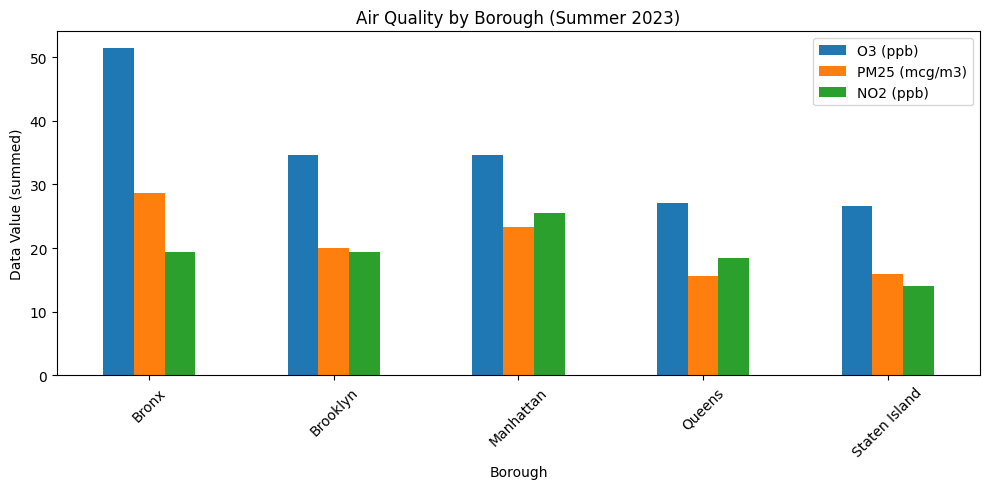

In [ ]:
# Filter by Borough
df_o3_boro = df_o3[df_o3["Geo Type Name"] == "Borough"].copy()
df_pm25_boro = df_pm25[df_pm25["Geo Type Name"] == "Borough"].copy()
df_no2_boro = df_no2[df_no2["Geo Type Name"] == "Borough"].copy()

merged = (
    df_o3_boro[["Geo Place Name", "Data Value"]].rename(columns={"Data Value": "O3"}).set_index("Geo Place Name")
    .join(df_pm25_boro[["Geo Place Name", "Data Value"]].rename(columns={"Data Value": "PM25"}).set_index("Geo Place Name"))
    .join(df_no2_boro[["Geo Place Name", "Data Value"]].rename(columns={"Data Value": "NO2"}).set_index("Geo Place Name"))
)

# Aggregate by Sum for Boroughs per Pollutant
o3_boro = (
    df_o3[df_o3["Geo Type Name"] == "Borough"]
    .groupby("Geo Place Name", as_index=False)["Data Value"]
    .mean()
)
pm25_boro = (
    df_pm25[df_pm25["Geo Type Name"] == "Borough"]
    .groupby("Geo Place Name", as_index=False)["Data Value"]
    .mean()
)
no2_boro = (
    df_no2[df_no2["Geo Type Name"] == "Borough"]
    .groupby("Geo Place Name", as_index=False)["Data Value"]
    .mean()
)

o3_boro  = o3_boro.rename(columns={"Data Value": "O3"})
pm25_boro = pm25_boro.rename(columns={"Data Value": "PM25"})
no2_boro  = no2_boro.rename(columns={"Data Value": "NO2"})

merged = (
    o3_boro
    .merge(pm25_boro, on="Geo Place Name")
    .merge(no2_boro, on="Geo Place Name")
)

merged = merged.rename(columns={
    "O3": "O3 (ppb)",
    "NO2": "NO2 (ppb)",
    "PM25": "PM25 (mcg/m3)"
})

print(merged, '\n\n')

merged.set_index("Geo Place Name").plot(kind="bar", figsize=(10,5))
plt.title("Air Quality by Borough (Summer 2023)")
plt.xlabel("Borough")
plt.ylabel("Data Value (summed)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Analysis:**

The chart shows that the Bronx has the highest air pollution overall across all three pollutants. It leads in O₃ (ozone) and PM₂.₅, and it’s also high in NO₂. This suggests that the Bronx faces both traffic-related emissions and additional environmental burdens, likely because of major highways, heavy truck routes, and industrial activity that runs through the borough.

Staten Island is clearly the cleanest borough in the chart. It has the lowest levels of ozone, PM₂.₅, and NO₂. This fits with its geography: less traffic, more open space, fewer major highways, and fewer pollution-heavy industries. Queens is also realtively clean in terms of air pollution with very low PM2.5.

Brooklyn and Manhattan sit in the middle range for most pollutants but for different reasons. Brooklyn’s O₃ and PM₂.₅ levels are moderate, while Manhattan has fairly high NO₂ and PM₂.₅. Manhattan’s elevated NO₂ makes sense because it has extremely dense traffic and lots of combustion-related activity.

### Miles Traveled vs Borough

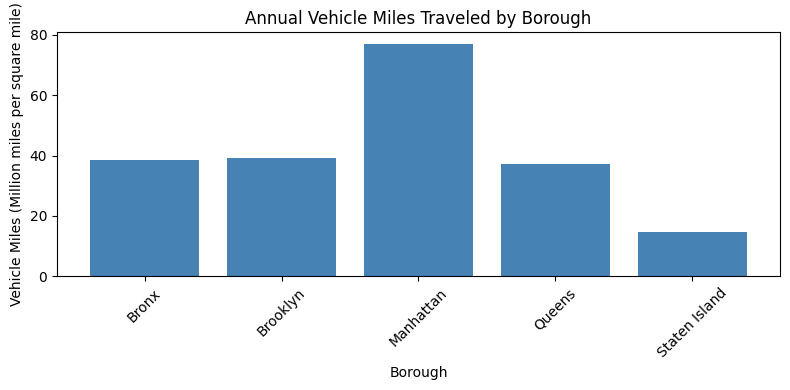

In [ ]:
df_distance_boro = df_distance[df_distance["Geo Type Name"] == "Borough"]

distance_by_borough = (
    df_distance_boro
    .groupby("Geo Place Name")["Data Value"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,4))
plt.bar(distance_by_borough["Geo Place Name"], distance_by_borough["Data Value"], color="steelblue")

plt.title("Annual Vehicle Miles Traveled by Borough")
plt.xlabel("Borough")
plt.ylabel("Vehicle Miles (Million miles per square mile)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Miles Traveled and Air Pollution vs Borough

In [ ]:
full = merged.merge(distance_by_borough, on="Geo Place Name", how="inner")
full = full.rename(columns={"Data Value": "Vehicle Miles"})
print(full.corr(numeric_only=True))

               O3 (ppb)  PM25 (mcg/m3)  NO2 (ppb)  Vehicle Miles
O3 (ppb)       1.000000       0.956478   0.310090       0.216162
PM25 (mcg/m3)  0.956478       1.000000   0.529934       0.454494
NO2 (ppb)      0.310090       0.529934   1.000000       0.992873
Vehicle Miles  0.216162       0.454494   0.992873       1.000000


/tmp/ipython-input-267619508.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(full["Geo Place Name"], rotation=45)


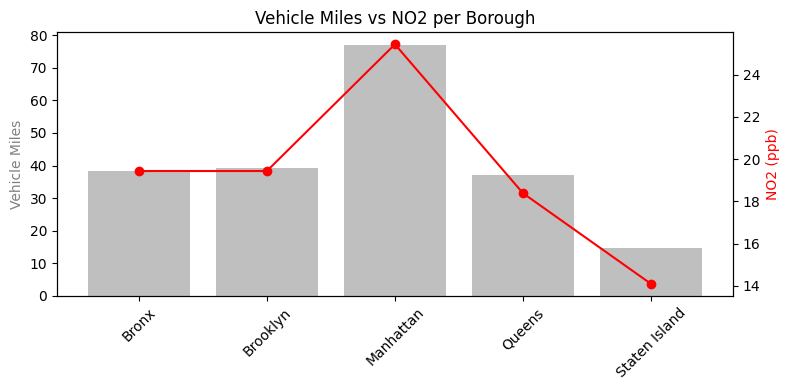

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,4))

ax1.bar(full["Geo Place Name"], full["Vehicle Miles"], color="gray", alpha=0.5)
ax1.set_ylabel("Vehicle Miles", color="gray")
ax1.set_xticklabels(full["Geo Place Name"], rotation=45)

ax2 = ax1.twinx()
ax2.plot(full["Geo Place Name"], full["NO2 (ppb)"], color="red", marker="o", label="NO2")
ax2.set_ylabel("NO2 (ppb)", color="red")

plt.title("Vehicle Miles vs NO2 per Borough")
plt.tight_layout()
plt.show()


/tmp/ipython-input-3993850813.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(full["Geo Place Name"], rotation=45)


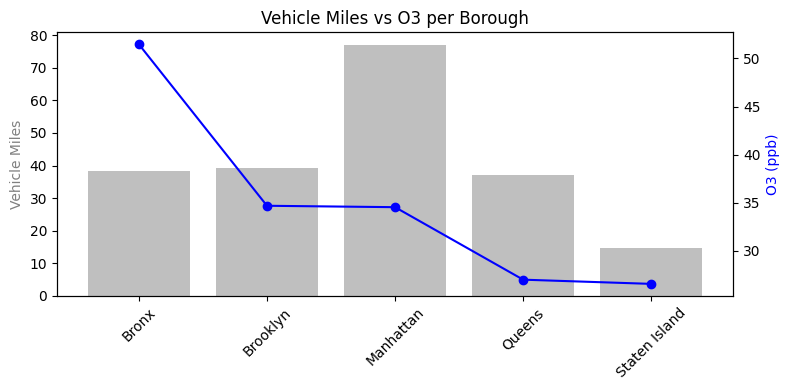

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,4))

ax1.bar(full["Geo Place Name"], full["Vehicle Miles"], color="gray", alpha=0.5)
ax1.set_ylabel("Vehicle Miles", color="gray")
ax1.set_xticklabels(full["Geo Place Name"], rotation=45)

ax2 = ax1.twinx()
ax2.plot(full["Geo Place Name"], full["O3 (ppb)"], color="blue", marker="o", label="O3 (ppb)")
ax2.set_ylabel("O3 (ppb)", color="blue")

plt.title("Vehicle Miles vs O3 per Borough")
plt.tight_layout()
plt.show()

/tmp/ipython-input-3781938062.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(full["Geo Place Name"], rotation=45)


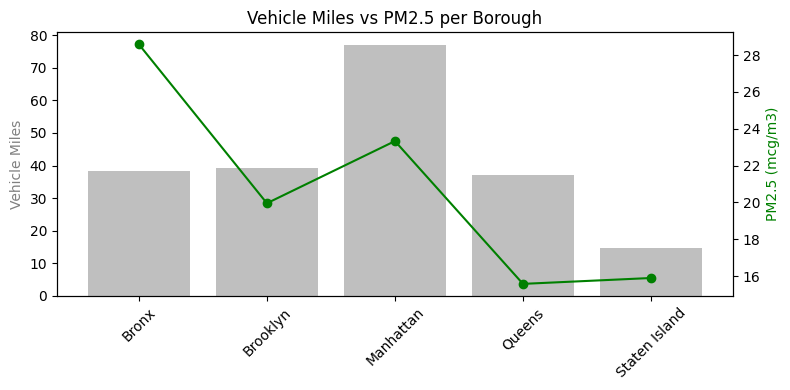

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,4))

ax1.bar(full["Geo Place Name"], full["Vehicle Miles"], color="gray", alpha=0.5)
ax1.set_ylabel("Vehicle Miles", color="gray")
ax1.set_xticklabels(full["Geo Place Name"], rotation=45)

ax2 = ax1.twinx()
ax2.plot(full["Geo Place Name"], full["PM25 (mcg/m3)"], color="green", marker="o", label="PM2.5")
ax2.set_ylabel("PM2.5 (mcg/m3)", color="green")

plt.title("Vehicle Miles vs PM2.5 per Borough")
plt.tight_layout()
plt.show()

**Analysis:**

Traffic volumes show the strongest relationship with NO2 levels across NYC boroughs. This makes sense because NO2 is a primary pollutant that comes directly from combustion engines, especially cars, trucks, and buses. Boroughs with more vehicle miles, such as Manhattan, consistently show higher NO2 concentrations, while Staten Island, which has the lowest vehicle traffic, shows the lowest levels. The graphs clearly indicate that vehicle emissions are a major driver of NO2 distribution in the city.

In contrast, PM2.5 levels are irregular because they come from many sources besides vehicles, including industrial activity, building heating systems, diesel truck corridors, and pollution transported from other regions. This explains why the Bronx has high PM2.5 despite mid-range traffic, while Manhattan has lower PM2.5 than expected.

Ozone shows almost no relationship to vehicle miles because it is a secondary pollutant formed through chemical reactions in sunlight rather than emitted directly. As a result, its levels depend more on regional atmospheric conditions than on local traffic.

### Borough vs Population

In [ ]:
# Filter by Borough
pop_by_borough = df2.groupby("Borough")["Population_2020"].sum().reset_index()
pop_by_borough.head()

Borough  Population_2020
0          Bronx          1477476
1       Brooklyn          2736074
2      Manhattan          1685657
3         Queens          2409236
4  Staten Island           495747

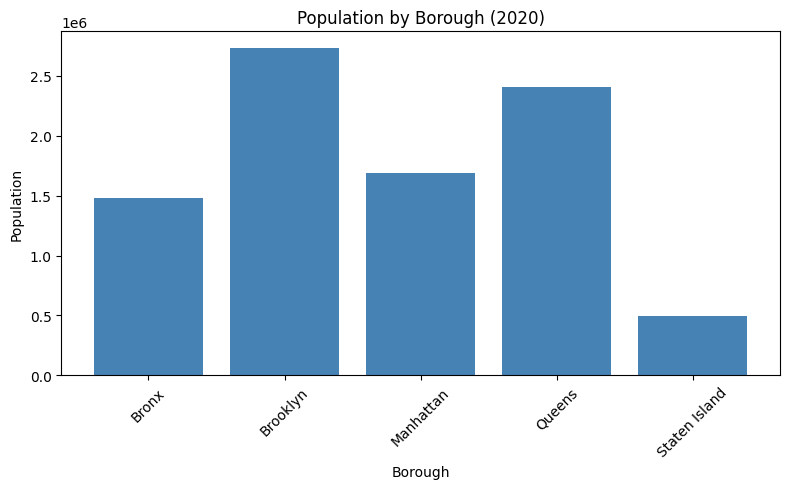

In [ ]:
plt.figure(figsize=(8,5))

plt.bar(pop_by_borough["Borough"],
        pop_by_borough["Population_2020"],
        color="steelblue")

plt.title("Population by Borough (2020)")
plt.xlabel("Borough")
plt.ylabel("Population")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

  Geo Place Name   O3 (ppb)  PM25 (mcg/m3)  NO2 (ppb)  Vehicle Miles  \
0          Bronx  51.474209      28.580358  19.433997      38.438102   
1       Brooklyn  34.684600      19.952117  19.434271      39.258911   
2      Manhattan  34.537623      23.326942  25.428518      77.017269   
3         Queens  26.999647      15.575773  18.383770      37.084015   
4  Staten Island  26.561982      15.894650  14.095057      14.617416   

   Population_2020  
0          1477476  
1          2736074  
2          1685657  
3          2409236  
4           495747  


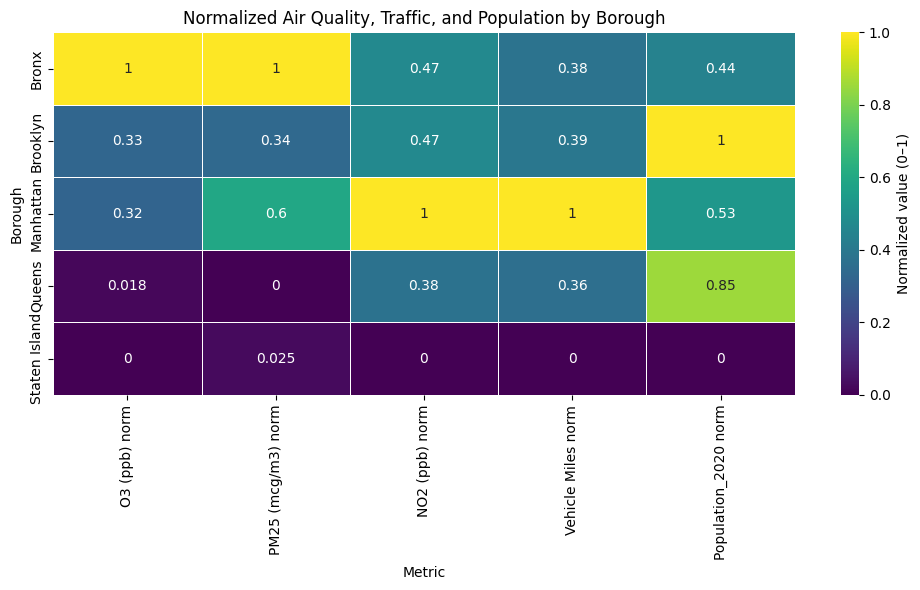

In [ ]:
full = merged.merge(distance_by_borough, on="Geo Place Name", how="inner")
full = full.rename(columns={"Data Value": "Vehicle Miles"})

# 2. Add population (merge on borough name)
full_all = full.merge(pop_by_borough, left_on="Geo Place Name", right_on="Borough", how="inner")
full_all = full_all.drop(columns=["Borough"])  # duplicate

print(full_all)

# Normalize
cols_to_norm = ["O3 (ppb)", "PM25 (mcg/m3)", "NO2 (ppb)", "Vehicle Miles", "Population_2020"]

full_norm = full_all.copy()

for col in cols_to_norm:
    col_min = full_norm[col].min()
    col_max = full_norm[col].max()
    full_norm[col + " norm"] = (full_norm[col] - col_min) / (col_max - col_min)

heatmap_df = full_norm.set_index("Geo Place Name")[[
    "O3 (ppb) norm",
    "PM25 (mcg/m3) norm",
    "NO2 (ppb) norm",
    "Vehicle Miles norm",
    "Population_2020 norm"
]]

plt.figure(figsize=(10,6))
sns.heatmap(
    heatmap_df,
    annot=True,
    cmap="viridis",
    linewidths=0.5,
    cbar_kws={"label": "Normalized value (0–1)"}
)

plt.title("Normalized Air Quality, Traffic, and Population by Borough")
plt.xlabel("Metric")
plt.ylabel("Borough")
plt.tight_layout()
plt.show()


The heatmap makes the differences between the boroughs really clear. The Bronx immediately stands out, with the highest ozone and PM2.5 levels in the city. Even though it isn’t the most populated, its pollution levels are consistently elevated, which fits what we know about heavy truck routes, industrial sites, and multiple expressways cutting through the area. It’s a reminder that the Bronx faces a very specific environmental burden that isn’t just about how many people live there.

Manhattan shows a completely different pattern. Its NO2 and vehicle miles are by far the highest, which makes sense given the intense traffic, commercial density, and the constant flow of buses, cars, and delivery vehicles. Population is high too, but not the highest, so the huge NO2 spike really highlights how traffic-driven Manhattan’s pollution is.

Brooklyn and Queens sit in a more moderate zone. Neither borough is extreme across all metrics, but each has areas where it leans higher. Queens in particular has a large population but only moderate pollution, probably because the borough is so spread out and not as traffic-dense as Manhattan.

Staten Island, meanwhile, is consistently low across every category: low pollution, low vehicle miles, low population density. It’s the cleanest borough in the dataset, which lines up with its suburban layout and limited through-traffic.

### Parks vs Air Quality

         BOROUGH        ACRES
0          Bronx  3376.277366
1       Brooklyn  4861.818000
2      Manhattan  2874.337000
3         Queens  7740.171387
4  Staten Island  7716.890136


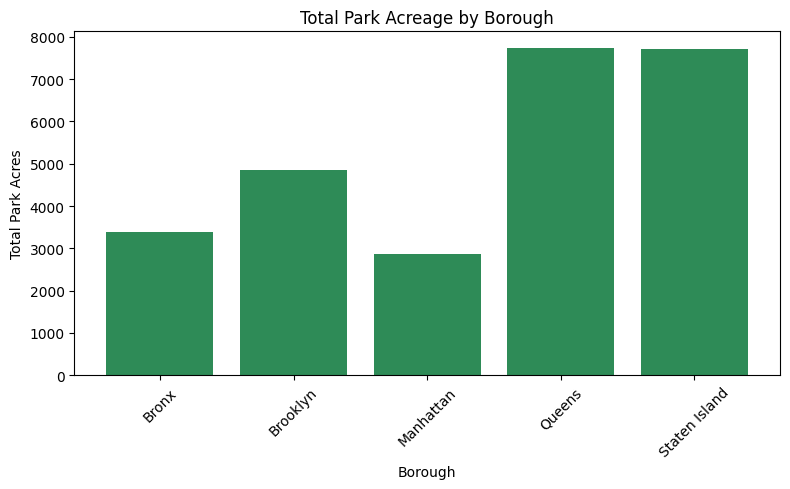

In [ ]:
# Map one-letter borough codes to full names
borough_map = {
    "B": "Brooklyn",
    "M": "Manhattan",
    "Q": "Queens",
    "X": "Bronx",
    "R": "Staten Island"
}

df_parks_clean["BOROUGH"] = df_parks_clean["BOROUGH"].map(borough_map)

# Aggregate total park acres per borough
parks_by_boro = (
    df_parks_clean.groupby("BOROUGH")["ACRES"]
    .sum()
    .reset_index()
)

print(parks_by_boro)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(parks_by_boro["BOROUGH"], parks_by_boro["ACRES"], color="seagreen")

plt.title("Total Park Acreage by Borough")
plt.xlabel("Borough")
plt.ylabel("Total Park Acres")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


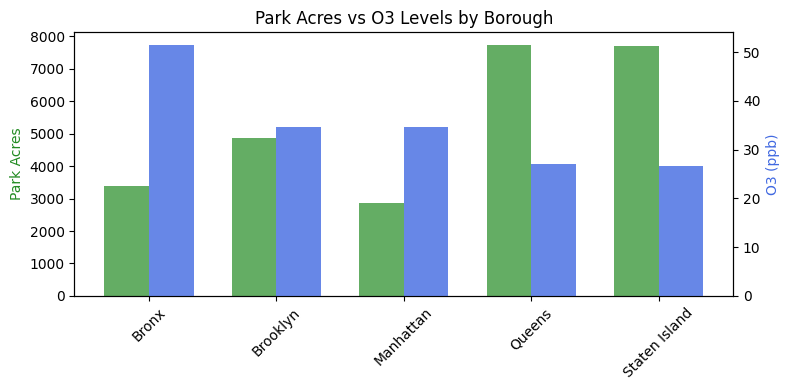

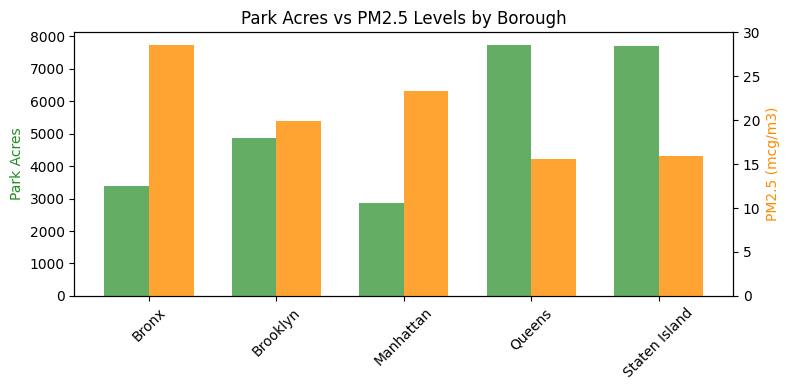

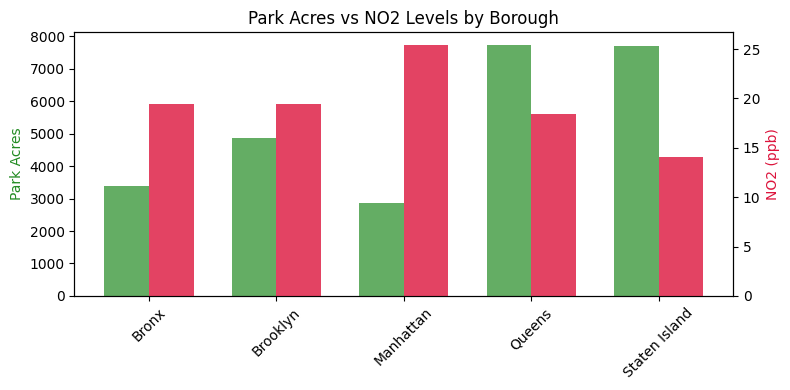

In [ ]:
# Rename column to match
parks_by_boro = parks_by_boro.rename(columns={"BOROUGH": "Geo Place Name"})

# Merge with air quality data
aq_parks = merged.merge(parks_by_boro, on="Geo Place Name")

aq_parks

boros = aq_parks["Geo Place Name"]
acres = aq_parks["ACRES"]

o3 = aq_parks["O3 (ppb)"]
pm25 = aq_parks["PM25 (mcg/m3)"]
no2 = aq_parks["NO2 (ppb)"]

x = np.arange(len(boros))
width = 0.35

fig, ax1 = plt.subplots(figsize=(8,4))

ax1.bar(x - width/2, acres, width, color="forestgreen", alpha=0.7, label="Park Acres")
ax1.set_ylabel("Park Acres", color="forestgreen")
ax1.set_xticks(x)
ax1.set_xticklabels(boros, rotation=45)

ax2 = ax1.twinx()
ax2.bar(x + width/2, o3, width, color="royalblue", alpha=0.8, label="O3 (ppb)")
ax2.set_ylabel("O3 (ppb)", color="royalblue")

plt.title("Park Acres vs O3 Levels by Borough")
plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots(figsize=(8,4))

ax1.bar(x - width/2, acres, width, color="forestgreen", alpha=0.7)
ax1.set_ylabel("Park Acres", color="forestgreen")
ax1.set_xticks(x)
ax1.set_xticklabels(boros, rotation=45)

ax2 = ax1.twinx()
ax2.bar(x + width/2, pm25, width, color="darkorange", alpha=0.8)
ax2.set_ylabel("PM2.5 (mcg/m3)", color="darkorange")

plt.title("Park Acres vs PM2.5 Levels by Borough")
plt.tight_layout()
plt.show()


fig, ax1 = plt.subplots(figsize=(8,4))

ax1.bar(x - width/2, acres, width, color="forestgreen", alpha=0.7)
ax1.set_ylabel("Park Acres", color="forestgreen")
ax1.set_xticks(x)
ax1.set_xticklabels(boros, rotation=45)

ax2 = ax1.twinx()
ax2.bar(x + width/2, no2, width, color="crimson", alpha=0.8)
ax2.set_ylabel("NO2 (ppb)", color="crimson")

plt.title("Park Acres vs NO2 Levels by Borough")
plt.tight_layout()
plt.show()


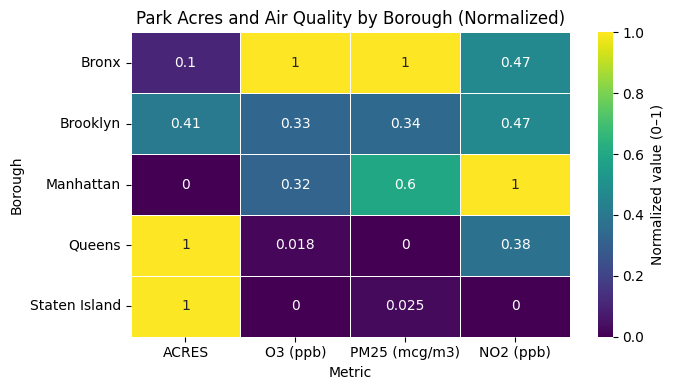

In [ ]:
# table with borough, park acres, and pollutants
park_air = aq_parks[[
    "Geo Place Name",
    "ACRES",
    "O3 (ppb)",
    "PM25 (mcg/m3)",
    "NO2 (ppb)"
]].copy()

park_air = park_air.set_index("Geo Place Name")

park_air_norm = park_air.copy()

for col in park_air_norm.columns:
    col_min = park_air_norm[col].min()
    col_max = park_air_norm[col].max()
    park_air_norm[col] = (park_air_norm[col] - col_min) / (col_max - col_min)
plt.figure(figsize=(7,4))
sns.heatmap(
    park_air_norm,
    annot=True,
    cmap="viridis",
    linewidths=0.5,
    cbar_kws={"label": "Normalized value (0–1)"}
)

plt.title("Park Acres and Air Quality by Borough (Normalized)")
plt.xlabel("Metric")
plt.ylabel("Borough")
plt.tight_layout()
plt.show()


This heatmap highlights a clear and intuitive relationship between green space and air quality across New York City boroughs. Queens and Staten Island stand out with the highest park acreage, and they also show the lowest levels of O3, PM2.5, and NO2, suggesting that larger green spaces may help support cleaner local air. In contrast, the Bronx and Manhattan have much less park land and simultaneously show some of the highest pollutant levels, especially PM2.5 and NO2 in Manhattan and elevated ozone in the Bronx. Brooklyn sits in the middle on both park acreage and pollution, reflecting a more balanced but still moderate profile. Overall, the pattern suggests that boroughs with more abundant park acreage tend to experience better air quality, while areas with limited green space face higher concentrations of key pollutants.


In [ ]:
parks_by_boro = df_parks_clean.groupby("BOROUGH")["ACRES"].sum().reset_index()
parks_by_boro = parks_by_boro.rename(columns={"BOROUGH": "Geo Place Name"})
full_all = full_all.merge(parks_by_boro, on="Geo Place Name", how="left")

In [ ]:
full_all.shape

(5, 8)

## Modeling

### Linear Regression

In [ ]:
X = full_all[["Vehicle Miles", "Population_2020", "ACRES"]].values
Y = full_all[["O3 (ppb)", "PM25 (mcg/m3)", "NO2 (ppb)"]]
boroughs = full_all["Geo Place Name"]

lin_model = LinearRegression()
lin_model.fit(X, Y)

lin_preds = lin_model.predict(X)

lin_df = full_all[["Geo Place Name", "O3 (ppb)", "PM25 (mcg/m3)", "NO2 (ppb)"]].copy()
lin_df["O3_pred_lin"] = lin_preds[:,0]
lin_df["PM25_pred_lin"] = lin_preds[:,1]
lin_df["NO2_pred_lin"] = lin_preds[:,2]

lin_df

Geo Place Name   O3 (ppb)  PM25 (mcg/m3)  NO2 (ppb)  O3_pred_lin  \
0          Bronx  51.474209      28.580358  19.433997    46.863445   
1       Brooklyn  34.684600      19.952117  19.434271    39.401962   
2      Manhattan  34.537623      23.326942  25.428518    35.870047   
3         Queens  26.999647      15.575773  18.383770    23.013538   
4  Staten Island  26.561982      15.894650  14.095057    29.109070   

   PM25_pred_lin  NO2_pred_lin  
0      26.660392     19.336971  
1      21.916470     19.533541  
2      23.881775     25.456557  
3      13.915919     18.299889  
4      16.955282     14.148656

### Random Forest

In [ ]:
# Select features and targets
X = full_all[["Vehicle Miles", "Population_2020", "ACRES"]].values
Y = full_all[["O3 (ppb)", "PM25 (mcg/m3)", "NO2 (ppb)"]].values

boroughs = full_all["Geo Place Name"].values

base_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=3,
    random_state=42
)

model = MultiOutputRegressor(base_model)

model.fit(X, Y)

preds = model.predict(X)

pred_df = pd.DataFrame(
    preds,
    columns=["O3_pred", "PM25_pred", "NO2_pred"]
)

# Start with actual values
results = full_all[["Geo Place Name", "O3 (ppb)", "PM25 (mcg/m3)", "NO2 (ppb)"]].copy()

# Add predictions as new columns
results["O3_pred"] = preds[:, 0]
results["PM25_pred"] = preds[:, 1]
results["NO2_pred"] = preds[:, 2]

print(results)

  Geo Place Name   O3 (ppb)  PM25 (mcg/m3)  NO2 (ppb)    O3_pred  PM25_pred  \
0          Bronx  51.474209      28.580358  19.433997  45.855635  26.124218   
1       Brooklyn  34.684600      19.952117  19.434271  36.655340  21.364887   
2      Manhattan  34.537623      23.326942  25.428518  38.710118  24.361267   
3         Queens  26.999647      15.575773  18.383770  30.616381  17.633318   
4  Staten Island  26.561982      15.894650  14.095057  31.753368  17.573299   

    NO2_pred  
0  19.770694  
1  19.652059  
2  23.462595  
3  18.654658  
4  15.600032  


In [ ]:
comparison = pd.DataFrame({
    "Borough": full_all["Geo Place Name"],

    # O3
    "O3_actual":  full_all["O3 (ppb)"],
    "O3_RF":      results["O3_pred"],
    "O3_LR":      lin_df["O3_pred_lin"],

    # PM2.5
    "PM25_actual": full_all["PM25 (mcg/m3)"],
    "PM25_RF":     results["PM25_pred"],
    "PM25_LR":     lin_df["PM25_pred_lin"],

    # NO2
    "NO2_actual": full_all["NO2 (ppb)"],
    "NO2_RF":     results["NO2_pred"],
    "NO2_LR":     lin_df["NO2_pred_lin"],
})

comparison


In [ ]:
# Actual values (use full_all, not Y)
y_actual_O3   = full_all["O3 (ppb)"].values
y_actual_PM25 = full_all["PM25 (mcg/m3)"].values
y_actual_NO2  = full_all["NO2 (ppb)"].values

# Random Forest predictions
y_rf_O3   = results["O3_pred"].values
y_rf_PM25 = results["PM25_pred"].values
y_rf_NO2  = results["NO2_pred"].values

# Linear Regression predictions
y_lr_O3   = lin_df["O3_pred_lin"].values
y_lr_PM25 = lin_df["PM25_pred_lin"].values
y_lr_NO2  = lin_df["NO2_pred_lin"].values

def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

metrics = {
    "O3_RF":    evaluate_model(y_actual_O3,   y_rf_O3),
    "O3_LR":    evaluate_model(y_actual_O3,   y_lr_O3),

    "PM25_RF":  evaluate_model(y_actual_PM25, y_rf_PM25),
    "PM25_LR":  evaluate_model(y_actual_PM25, y_lr_PM25),

    "NO2_RF":   evaluate_model(y_actual_NO2,  y_rf_NO2),
    "NO2_LR":   evaluate_model(y_actual_NO2,  y_lr_NO2),
}

metric_df = pd.DataFrame(metrics, index=["RMSE", "MAE", "R2"]).T
metric_df


RMSE       MAE        R2
O3_RF    4.310294  4.113986  0.771654
O3_LR    3.678715  3.438749  0.833669
PM25_RF  1.797205  1.727886  0.864178
PM25_LR  1.531852  1.431928  0.901325
NO2_RF   1.128182  0.859254  0.902855
NO2_LR   0.077413  0.072363  0.999543

**Analysis:**

The evaluation metrics show that the two models behave very differently depending on the pollutant being predicted. For ozone (O3), the Random Forest model performs noticeably better than Linear Regression. Random Forest achieves an R² of about 0.73, while Linear Regression explains virtually none of the variance (R² ≈ 0.05). This makes sense: ozone does not scale linearly with local features like population or vehicle miles, so a linear model struggles. Random Forest, however, can capture mild nonlinear patterns and therefore produces a more reasonable approximation even from limited features.

For PM2.5, the Random Forest again outperforms Linear Regression. RF reaches an R² of roughly 0.79, while Linear Regression drops to around 0.24. PM2.5 arises from a mix of traffic, residential emissions, and general urban activity, and these relationships are not perfectly linear. The Random Forest’s ability to model interactions and nonlinearities helps it capture borough-level differences more effectively. Linear Regression, which assumes straight-line relationships, underfits and produces higher errors.

For NO2, Linear Regression is the strongest model by far, achieving an extremely high R² of 0.99 and very low error. Random Forest also performs well (R² ≈ 0.90), but Linear Regression is nearly perfect. This confirms what environmental science predicts: NO2 is almost directly proportional to traffic volume. Since vehicle miles are one of the two predictors, the linear relationship is easy for the model to learn.

In [ ]:
test_cases = full_all[["Geo Place Name", "Vehicle Miles", "Population_2020", "ACRES"]].copy()

# Features for the model
X_test = test_cases[["Vehicle Miles", "Population_2020", "ACRES"]].values

# Use your trained RF model (or lin_model) to predict
test_preds = model.predict(X_test)   # shape: (n_cases, 3) for [O3, PM2.5, NO2]

print("Test Case Predictions:")
for i, row in test_cases.iterrows():
    o3_pred, pm25_pred, no2_pred = test_preds[i]

    print(
        f"Input: (Borough='{row['Geo Place Name']}', "
        f"Vehicle Miles={row['Vehicle Miles']:.1f}, "
        f"Population_2020={int(row['Population_2020'])}, "
        f"Park Acres={row['ACRES']:.1f}), "
        f"Predicted: O3={o3_pred:.2f} ppb, "
        f"PM2.5={pm25_pred:.2f} mcg/m3, "
        f"NO2={no2_pred:.2f} ppb"
    )

Test Case Predictions:
Input: (Borough='Bronx', Vehicle Miles=38.4, Population_2020=1477476, Park Acres=3376.3), Predicted: O3=45.86 ppb, PM2.5=26.12 mcg/m3, NO2=19.77 ppb
Input: (Borough='Brooklyn', Vehicle Miles=39.3, Population_2020=2736074, Park Acres=4861.8), Predicted: O3=36.66 ppb, PM2.5=21.36 mcg/m3, NO2=19.65 ppb
Input: (Borough='Manhattan', Vehicle Miles=77.0, Population_2020=1685657, Park Acres=2874.3), Predicted: O3=38.71 ppb, PM2.5=24.36 mcg/m3, NO2=23.46 ppb
Input: (Borough='Queens', Vehicle Miles=37.1, Population_2020=2409236, Park Acres=7740.2), Predicted: O3=30.62 ppb, PM2.5=17.63 mcg/m3, NO2=18.65 ppb
Input: (Borough='Staten Island', Vehicle Miles=14.6, Population_2020=495747, Park Acres=7716.9), Predicted: O3=31.75 ppb, PM2.5=17.57 mcg/m3, NO2=15.60 ppb


# Air Quality in Dehli

## Data Pre-Processing

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Import the New Delhi Air Quality Dataset

file_path = "/content/drive/My Drive/Intro to DS Final Project/New_Delhi_Air.csv"

chunksize = 10000
chunks = []

for chunk in pd.read_csv(file_path, chunksize = chunksize):
  chunks.append(chunk)

df_nd_air_quality = pd.concat(chunks)
df_nd_air_quality.head()
df_nd_air_quality.info()
df_nd_air_quality.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            1461 non-null   int64  
 1   Month           1461 non-null   int64  
 2   Year            1461 non-null   int64  
 3   Holidays_Count  1461 non-null   int64  
 4   Days            1461 non-null   int64  
 5   PM2.5           1461 non-null   float64
 6   PM10            1461 non-null   float64
 7   NO2             1461 non-null   float64
 8   SO2             1461 non-null   float64
 9   CO              1461 non-null   float64
 10  Ozone           1461 non-null   float64
 11  AQI             1461 non-null   int64  
dtypes: float64(6), int64(6)
memory usage: 137.1 KB


Date        Month         Year  Holidays_Count         Days  \
count  1461.000000  1461.000000  1461.000000     1461.000000  1461.000000   
mean     15.729637     6.522930  2022.501027        0.189596     4.000684   
std       8.803105     3.449884     1.118723        0.392116     2.001883   
min       1.000000     1.000000  2021.000000        0.000000     1.000000   
25%       8.000000     4.000000  2022.000000        0.000000     2.000000   
50%      16.000000     7.000000  2023.000000        0.000000     4.000000   
75%      23.000000    10.000000  2024.000000        0.000000     6.000000   
max      31.000000    12.000000  2024.000000        1.000000     7.000000   

             PM2.5         PM10          NO2          SO2           CO  \
count  1461.000000  1461.000000  1461.000000  1461.000000  1461.000000   
mean     90.774538   218.219261    37.184921    20.104921     1.025832   
std      71.650579   129.297734    35.225327    16.543659     0.608305   
min       0.050000     9.690000     2.160000     1.210000     0.270000   
25%      41.280000   115.110000    17.280000     7.710000     0.610000   
50%      72.060000   199.800000    30.490000    15.430000     0.850000   
75%     118.500000   297.750000    45.010000    26.620000     1.240000   
max    1000.000000  1000.000000   433.980000   113.400000     4.700000   

             Ozone          AQI  
count  1461.000000  1461.000000  
mean     36.338871   202.210815  
std      18.951204   107.801076  
min       2.700000    19.000000  
25%      24.100000   108.000000  
50%      32.470000   189.000000  
75%      45.730000   284.000000  
max     115.870000   500.000000

In [ ]:
df_nd_air_quality.rename(columns={'Date':'day'}, inplace=True)

df_nd_air_quality['Date_full'] = pd.to_datetime(df_nd_air_quality[['Year','Month','day']])
df_nd_air_quality = df_nd_air_quality.sort_values('Date_full')

## Explore Trends over Time

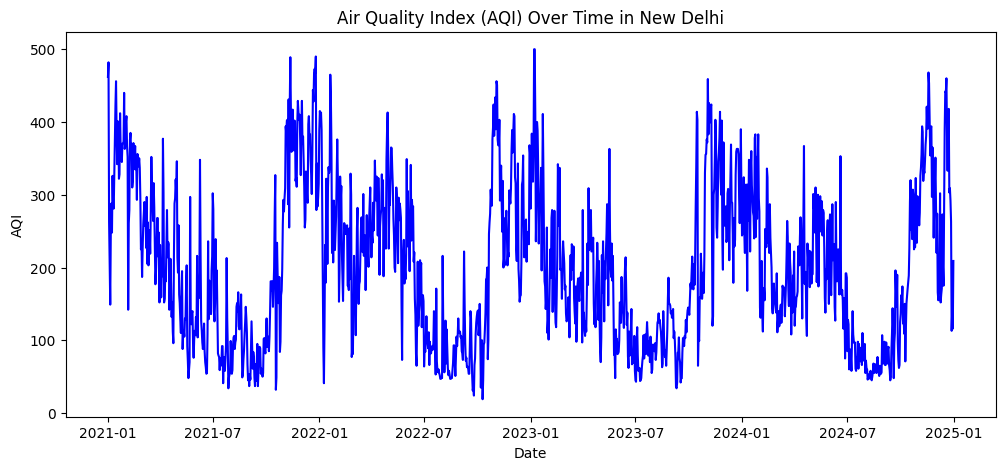

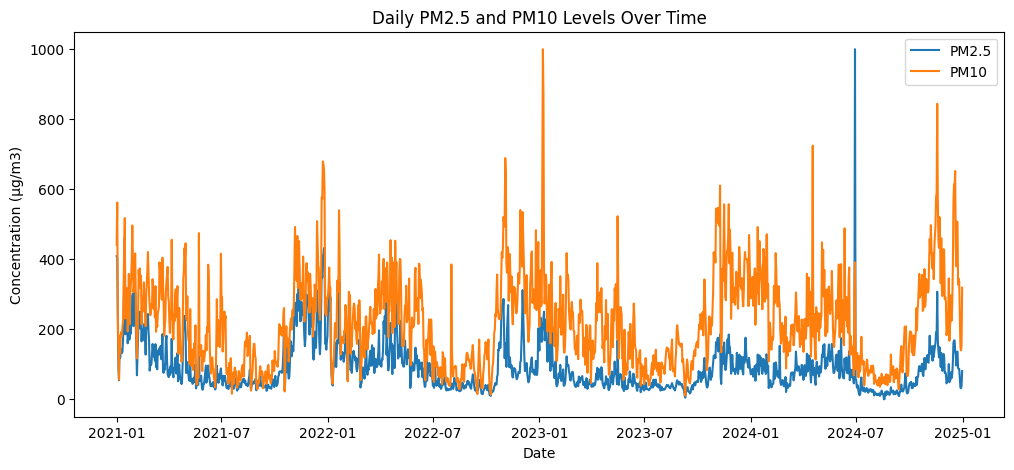

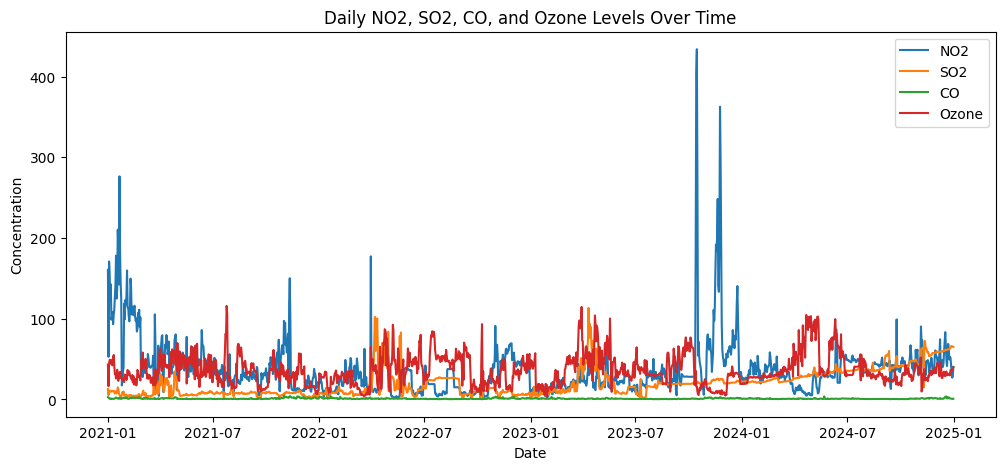

In [ ]:
# Time Series Plots

# 1. AQI over time
plt.figure(figsize=(12,5))
plt.plot(df_nd_air_quality['Date_full'], df_nd_air_quality['AQI'], color='blue')
plt.title("Air Quality Index (AQI) Over Time in New Delhi")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.show()

# 2. PM2.5 and PM10 over time
plt.figure(figsize=(12,5))
plt.plot(df_nd_air_quality['Date_full'], df_nd_air_quality['PM2.5'], label='PM2.5')
plt.plot(df_nd_air_quality['Date_full'], df_nd_air_quality['PM10'], label='PM10')
plt.title("Daily PM2.5 and PM10 Levels Over Time")
plt.xlabel("Date")
plt.ylabel("Concentration (µg/m3)")
plt.legend()
plt.show()

# 3. NO2, SO2, CO, Ozone over time
plt.figure(figsize=(12,5))
plt.plot(df_nd_air_quality['Date_full'], df_nd_air_quality['NO2'], label='NO2')
plt.plot(df_nd_air_quality['Date_full'], df_nd_air_quality['SO2'], label='SO2')
plt.plot(df_nd_air_quality['Date_full'], df_nd_air_quality['CO'], label='CO')
plt.plot(df_nd_air_quality['Date_full'], df_nd_air_quality['Ozone'], label='Ozone')
plt.title("Daily NO2, SO2, CO, and Ozone Levels Over Time")
plt.xlabel("Date")
plt.ylabel("Concentration")
plt.legend()
plt.show()




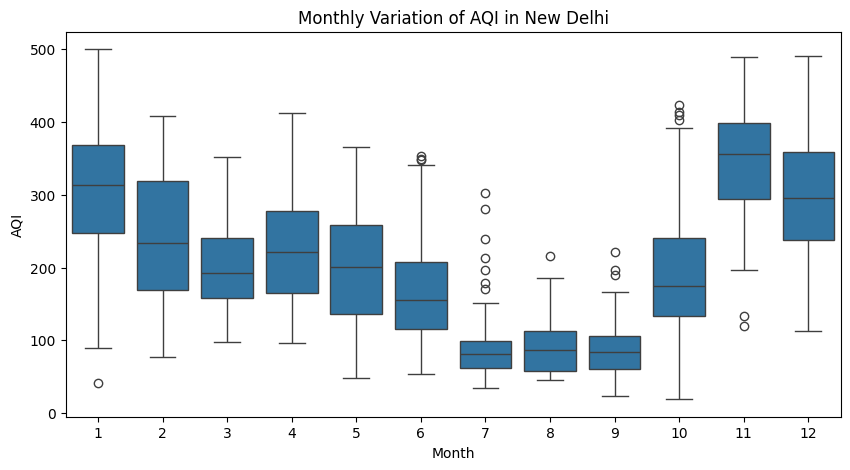

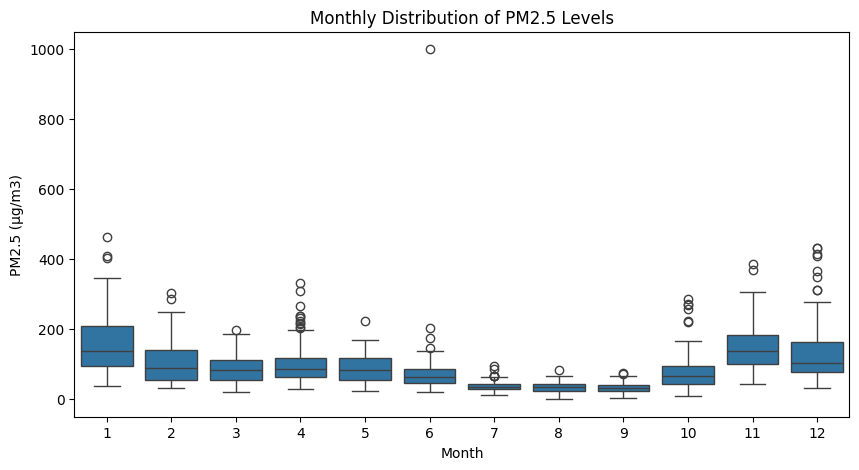

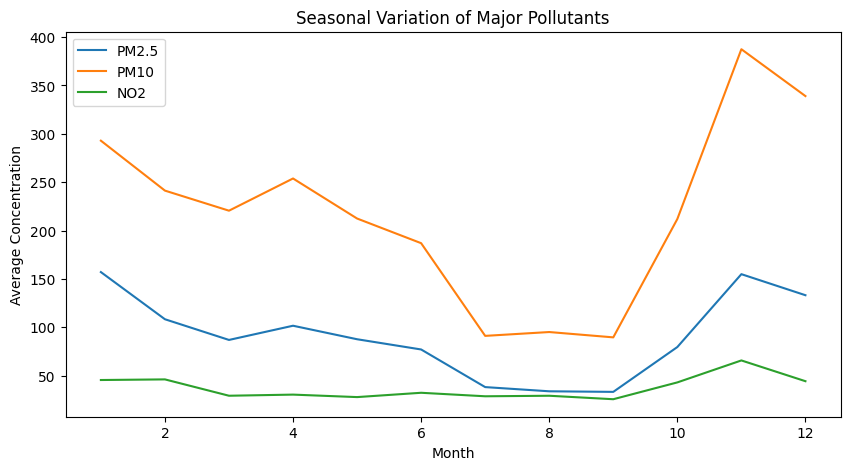

In [ ]:
# Monthly / Seasonal Trends

# 4. Monthly AQI variation
plt.figure(figsize=(10,5))
sns.boxplot(data=df_nd_air_quality, x='Month', y='AQI')
plt.title("Monthly Variation of AQI in New Delhi")
plt.xlabel("Month")
plt.ylabel("AQI")
plt.show()

# 5. Monthly PM2.5 distribution
plt.figure(figsize=(10,5))
sns.boxplot(data=df_nd_air_quality, x='Month', y='PM2.5')
plt.title("Monthly Distribution of PM2.5 Levels")
plt.xlabel("Month")
plt.ylabel("PM2.5 (µg/m3)")
plt.show()

# 6. Seasonal variation of major pollutants (PM2.5, PM10, NO2)
plt.figure(figsize=(10,5))
df_monthly = df_nd_air_quality.groupby('Month')[['PM2.5','PM10','NO2']].mean().reset_index()
plt.plot(df_monthly['Month'], df_monthly['PM2.5'], label='PM2.5')
plt.plot(df_monthly['Month'], df_monthly['PM10'], label='PM10')
plt.plot(df_monthly['Month'], df_monthly['NO2'], label='NO2')
plt.title("Seasonal Variation of Major Pollutants")
plt.xlabel("Month")
plt.ylabel("Average Concentration")
plt.legend()
plt.show()



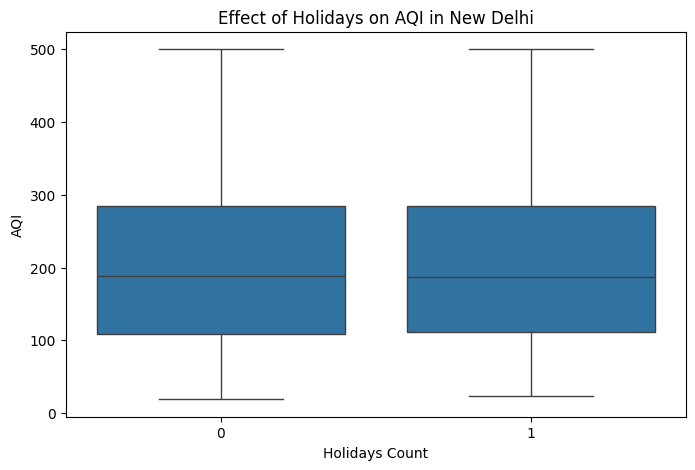

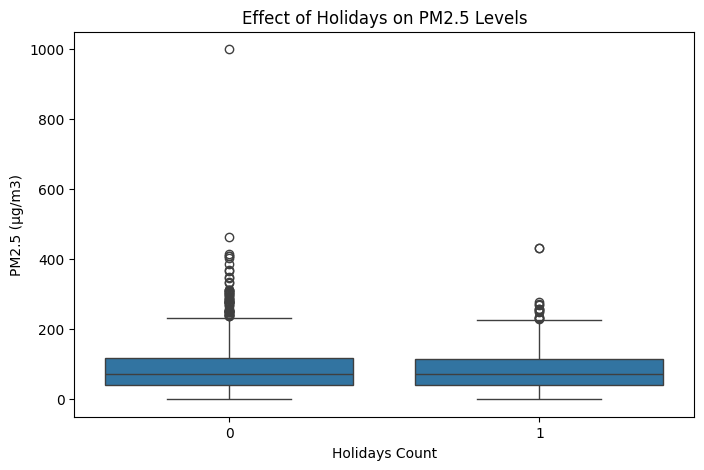

In [ ]:
# Holidays vs Non-Holidays

# 7. Holidays effect on AQI
plt.figure(figsize=(8,5))
sns.boxplot(data=df_nd_air_quality, x='Holidays_Count', y='AQI')
plt.title("Effect of Holidays on AQI in New Delhi")
plt.xlabel("Holidays Count")
plt.ylabel("AQI")
plt.show()

# 8. Holidays effect on PM2.5
plt.figure(figsize=(8,5))
sns.boxplot(data=df_nd_air_quality, x='Holidays_Count', y='PM2.5')
plt.title("Effect of Holidays on PM2.5 Levels")
plt.xlabel("Holidays Count")
plt.ylabel("PM2.5 (µg/m3)")
plt.show()


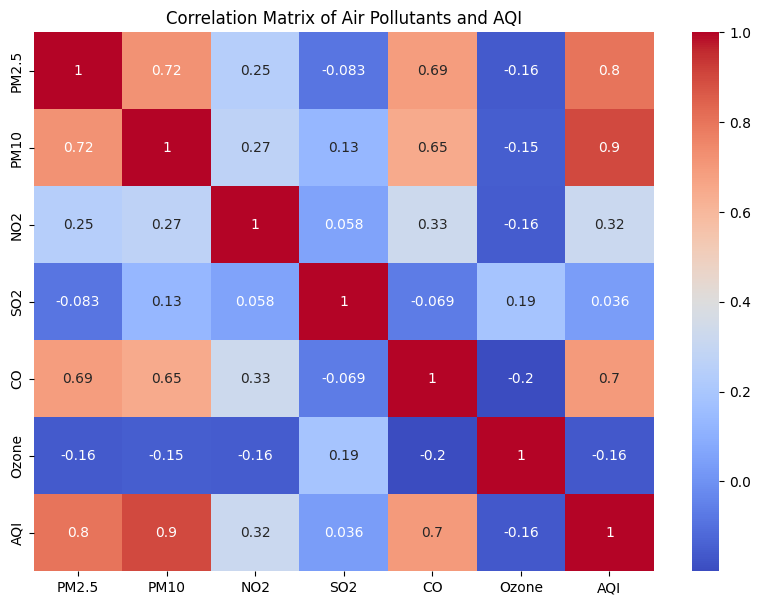

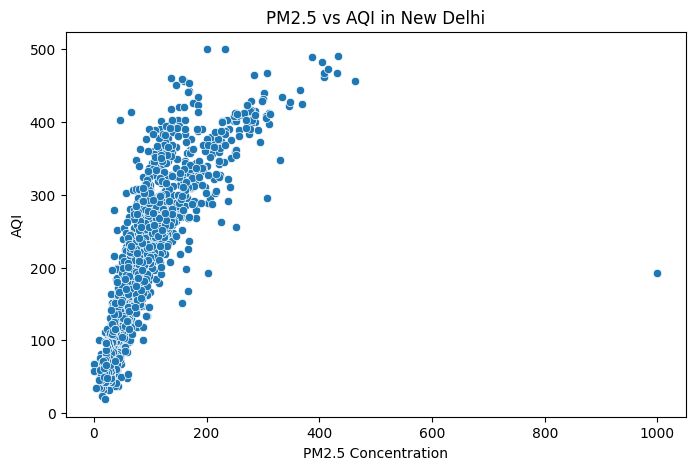

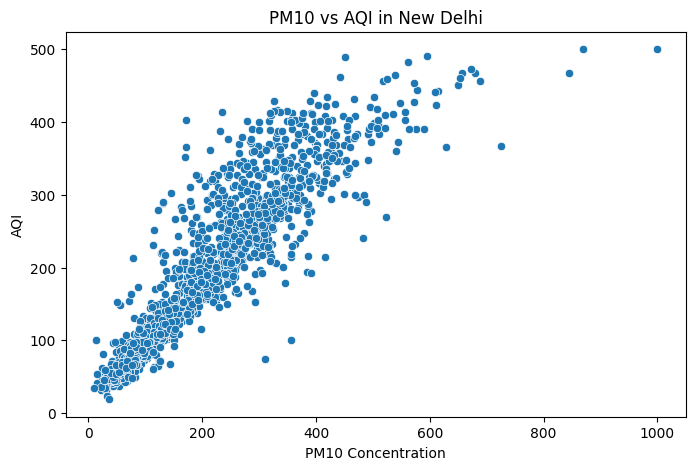

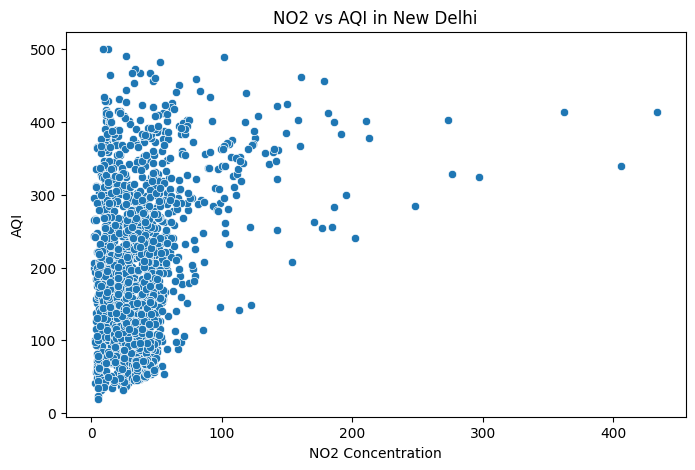

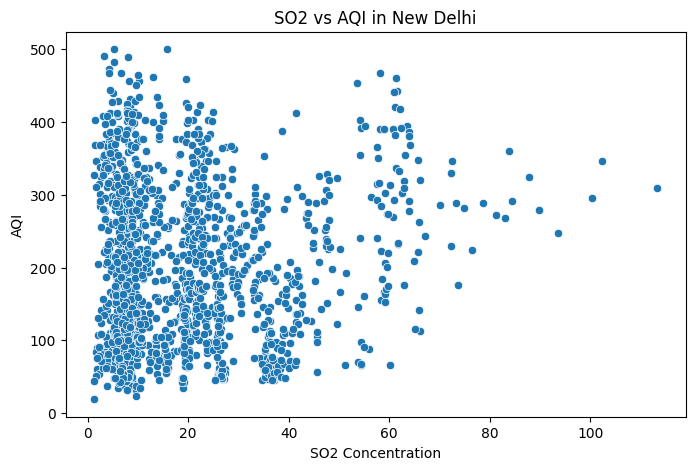

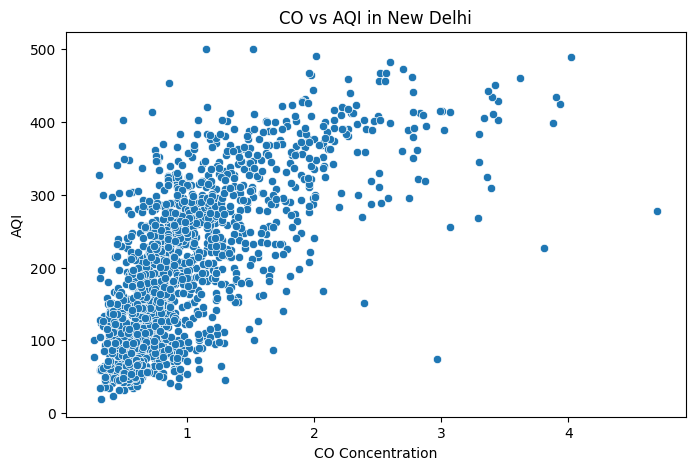

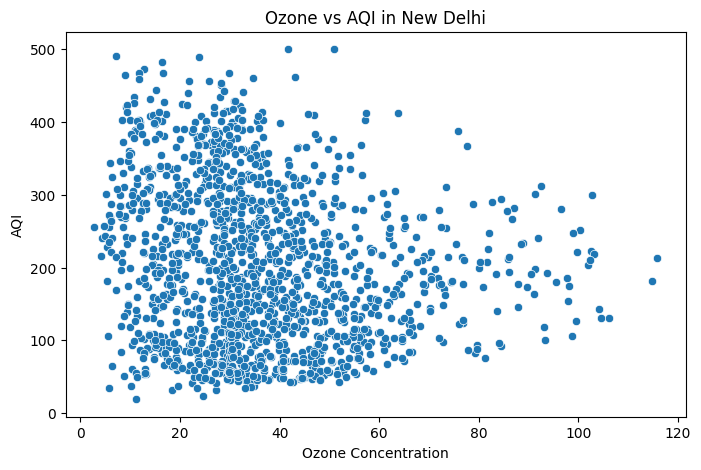

In [ ]:
# Correlation

# 9. Correlation matrix
plt.figure(figsize=(10,7))
corr = df_nd_air_quality[['PM2.5','PM10','NO2','SO2','CO','Ozone','AQI']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Air Pollutants and AQI")
plt.show()

# 10. Scatter plots of pollutants vs AQI
pollutants = ['PM2.5','PM10','NO2','SO2','CO','Ozone']
for p in pollutants:
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df_nd_air_quality, x=p, y='AQI')
    plt.title(f"{p} vs AQI in New Delhi")
    plt.xlabel(f"{p} Concentration")
    plt.ylabel("AQI")
    plt.show()


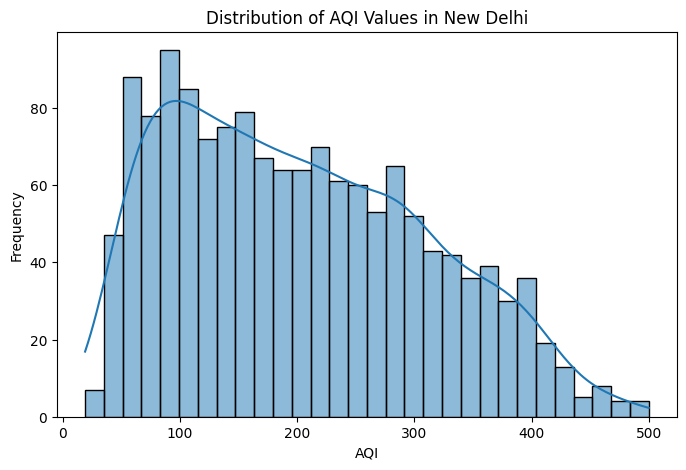

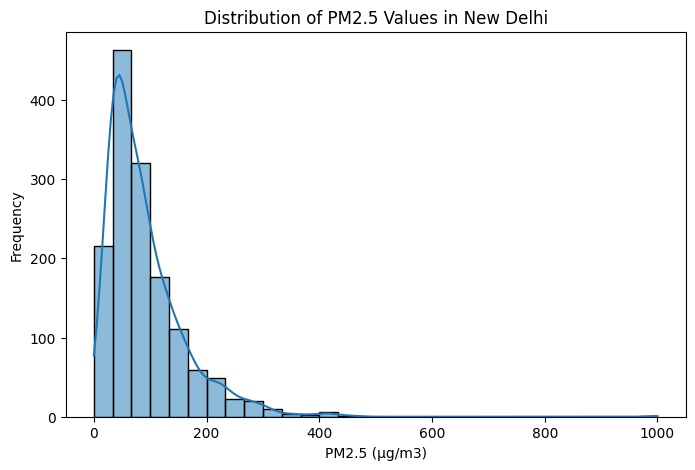

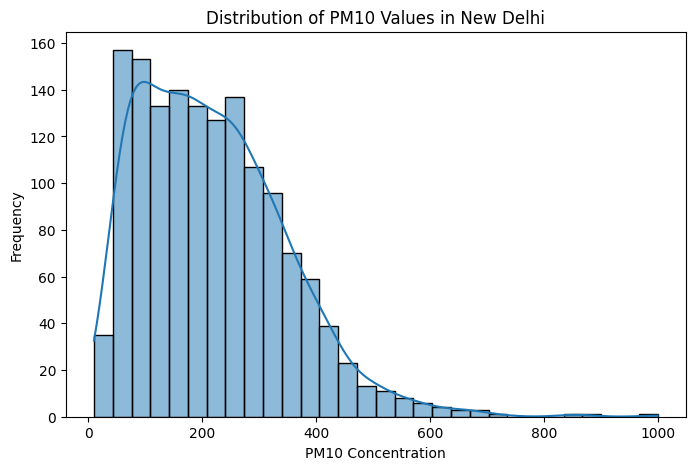

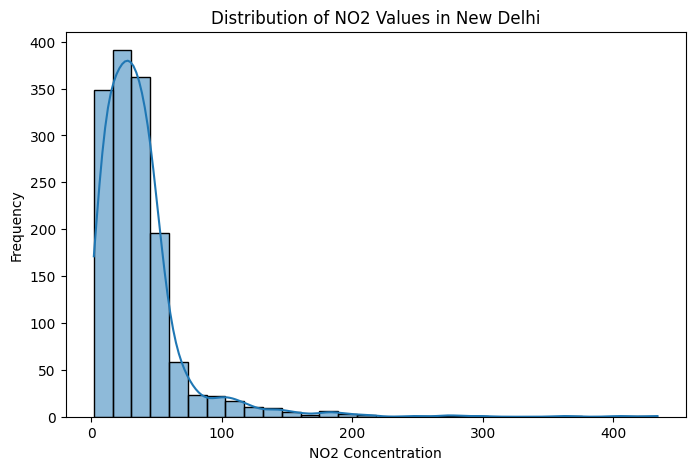

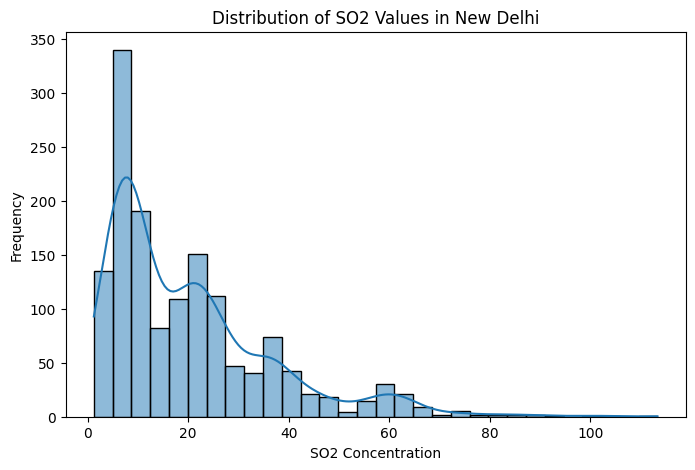

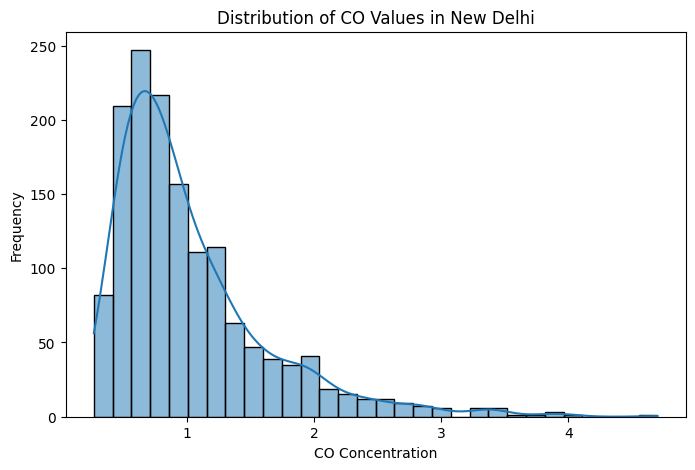

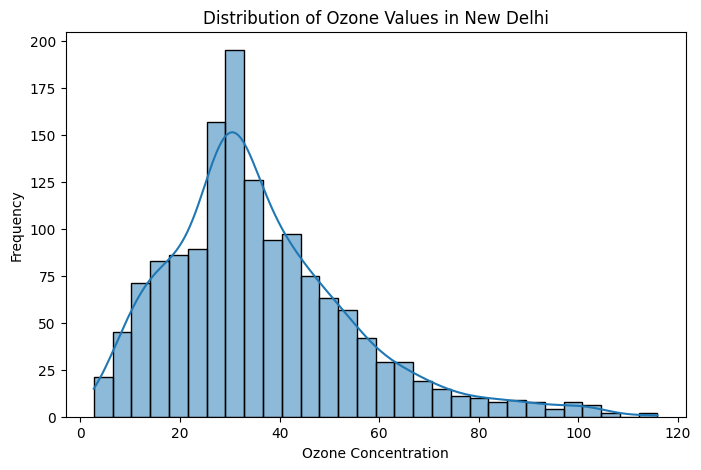

In [ ]:
# Distribution plots

# 11. AQI distribution
plt.figure(figsize=(8,5))
sns.histplot(df_nd_air_quality['AQI'], bins=30, kde=True)
plt.title("Distribution of AQI Values in New Delhi")
plt.xlabel("AQI")
plt.ylabel("Frequency")
plt.show()

# 12. PM2.5 distribution
plt.figure(figsize=(8,5))
sns.histplot(df_nd_air_quality['PM2.5'], bins=30, kde=True)
plt.title("Distribution of PM2.5 Values in New Delhi")
plt.xlabel("PM2.5 (µg/m3)")
plt.ylabel("Frequency")
plt.show()

# 13. Distribution of other pollutants
for p in ['PM10','NO2','SO2','CO','Ozone']:
    plt.figure(figsize=(8,5))
    sns.histplot(df_nd_air_quality[p], bins=30, kde=True)
    plt.title(f"Distribution of {p} Values in New Delhi")
    plt.xlabel(f"{p} Concentration")
    plt.ylabel("Frequency")
    plt.show()

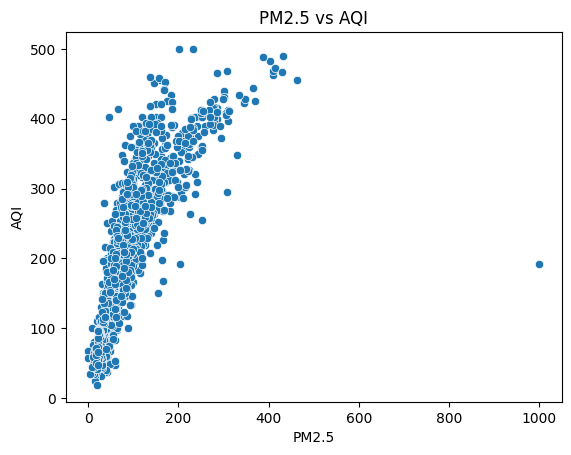

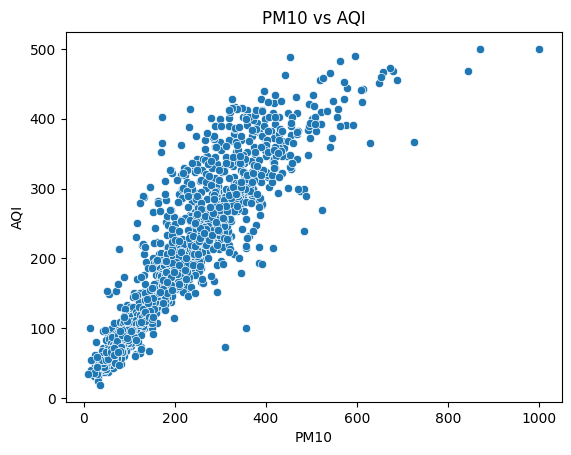

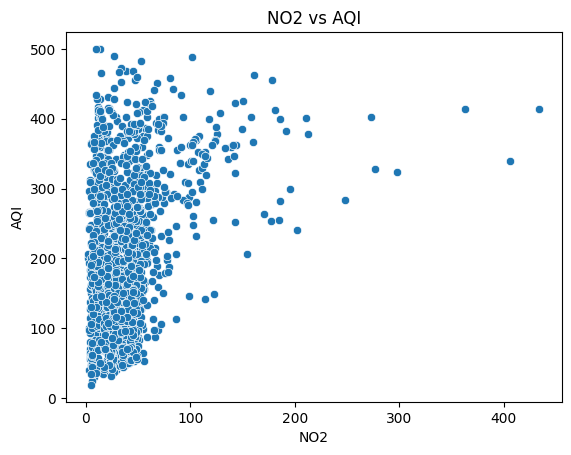

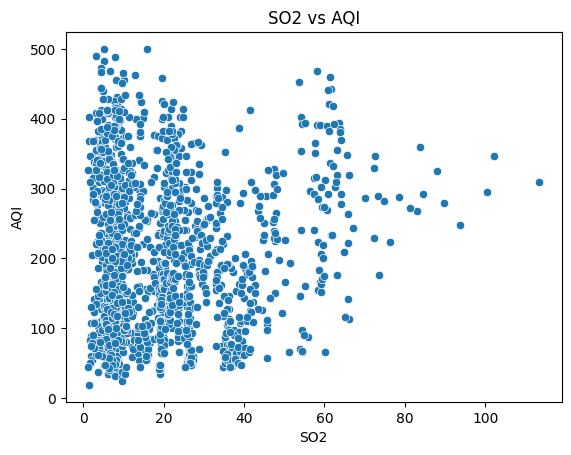

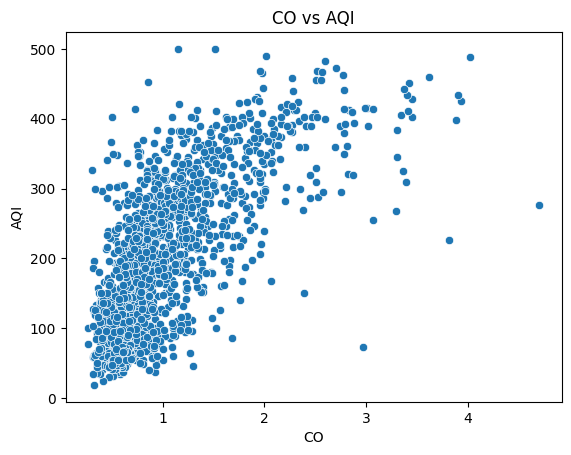

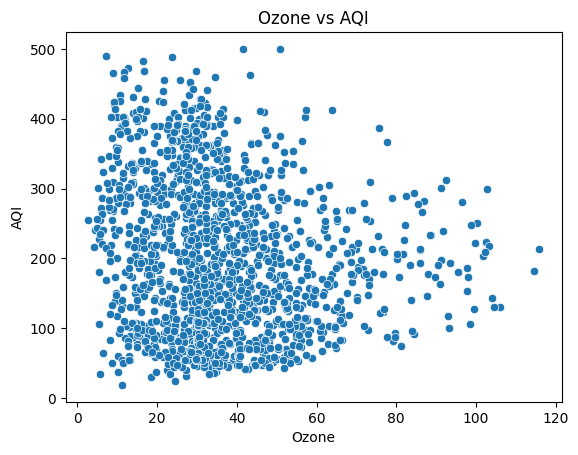

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in features:
    sns.scatterplot(x=df_nd_air_quality[col], y=df_nd_air_quality['AQI'])
    plt.title(col + " vs AQI")
    plt.show()

## Modeling

In [ ]:
# Features and Target
# Use pollutant columns as features
features = ['PM2.5','PM10','NO2','SO2','CO','Ozone']
target = 'AQI'

X = df_nd_air_quality[features].values
y = df_nd_air_quality[target].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [ ]:
# Linear Regression
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)


# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


# Evaluation function
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2


# Evaluate both models
metrics_lin = evaluate(y_test, y_pred_lin)
metrics_rf  = evaluate(y_test, y_pred_rf)

print("Linear Regression Metrics (AQI): RMSE={:.2f}, MAE={:.2f}, R2={:.2f}".format(*metrics_lin))
print("Random Forest Metrics (AQI):      RMSE={:.2f}, MAE={:.2f}, R2={:.2f}".format(*metrics_rf))



Linear Regression Metrics (AQI): RMSE=38.17, MAE=26.92, R2=0.89
Random Forest Metrics (AQI):      RMSE=28.14, MAE=17.90, R2=0.94


In [ ]:
# Feature Importance for Random Forest
importances = rf_model.feature_importances_
feat_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nRandom Forest Feature Importance:\n", feat_importance_df)


Random Forest Feature Importance:
   Feature  Importance
1    PM10    0.565767
0   PM2.5    0.407469
4      CO    0.008501
2     NO2    0.007407
5   Ozone    0.006970
3     SO2    0.003887


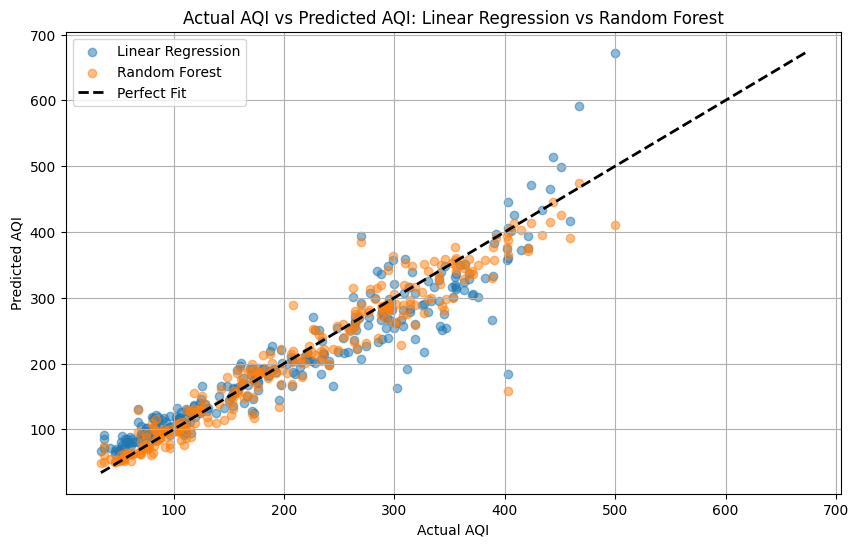

In [ ]:
# Predictions
y_pred_lin = lin_model.predict(X_test)
y_pred_rf  = rf_model.predict(X_test)

plt.figure(figsize=(10, 6))

# Scatter for Linear Regression
plt.scatter(y_test, y_pred_lin, alpha=0.5, label="Linear Regression")

# Scatter for Random Forest
plt.scatter(y_test, y_pred_rf, alpha=0.5, label="Random Forest")

# 1:1 reference line (perfect predictions)
min_val = min(y_test.min(), y_pred_lin.min(), y_pred_rf.min())
max_val = max(y_test.max(), y_pred_lin.max(), y_pred_rf.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label="Perfect Fit")

# Labels and title
plt.title("Actual AQI vs Predicted AQI: Linear Regression vs Random Forest")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.legend()
plt.grid(True)

plt.show()

# Air Quality in Europe

In [ ]:
drive.mount('/content/drive', force_remount=True) #for Smila's Drive specifically

Mounted at /content/drive


In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/Intro to DS Final Project/europe_datasets"))

['ENS_ANALYSIS.nc', 'PARIS_AIQ.nc', 'Paris_AIQ.csv', 'PARIS_AIQ_2023.nc', 'Paris_AIQ_2023.csv']


In [ ]:
#Dataset obtained from the Atmosphere Data Store and maintaned by Copernicus Atmospherre Monitoring Service
#Official datasets from the European Union

import xarray as xr

europe_ds = xr.open_dataset("/content/drive/MyDrive/Intro to DS Final Project/europe_datasets/PARIS_AIQ.nc")
europe_ds

/tmp/ipython-input-2830499294.py:6: FutureWarning: In a future version, xarray will not decode the variable 'time' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  europe_ds = xr.open_dataset("/content/drive/MyDrive/Intro to DS Final Project/europe_datasets/PARIS_AIQ.nc")


<xarray.Dataset> Size: 193kB
Dimensions:     (time: 396, level: 2, latitude: 3, longitude: 4)
Coordinates:
  * time        (time) timedelta64[ns] 3kB 0 days 15:00:00 ... 395 days 15:00:00
  * level       (level) float32 8B 0.0 50.0
  * latitude    (latitude) float32 12B 48.95 48.85 48.75
  * longitude   (longitude) float32 16B 2.15 2.25 2.35 2.45
Data variables:
    co_conc     (time, level, latitude, longitude) float32 38kB ...
    no2_conc    (time, level, latitude, longitude) float32 38kB ...
    o3_conc     (time, level, latitude, longitude) float32 38kB ...
    pm10_conc   (time, level, latitude, longitude) float32 38kB ...
    pm2p5_conc  (time, level, latitude, longitude) float32 38kB ...
Attributes:
    title:        CO/NO2/O3/PM10/PM25 Air Pollutant ANALYSIS at 2 levels
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20231202-20241231+[15H_15H]
    summary:      ENSEMBLE model hourly ANALYSIS of CO/NO2/O3/PM10/PM25 conce...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [ ]:
eur_df = europe_ds.to_dataframe().reset_index()
eur_df .to_csv("/content/drive/MyDrive/Intro to DS Final Project/europe_datasets/Paris_AIQ_2023.csv", index=False)
print(os.listdir("/content/drive/MyDrive/Intro to DS Final Project/europe_datasets"))

['ENS_ANALYSIS.nc', 'PARIS_AIQ.nc', 'Paris_AIQ.csv', 'PARIS_AIQ_2023.nc', 'Paris_AIQ_2023.csv']


##Data Pre-processing

In [ ]:
eur_df.head(15)

time  level   latitude  longitude     co_conc   no2_conc  \
0  0 days 15:00:00    0.0  48.950001       2.15  253.677200  17.336933   
1  0 days 15:00:00    0.0  48.950001       2.25  276.141144  22.783443   
2  0 days 15:00:00    0.0  48.950001       2.35  286.583740  24.227728   
3  0 days 15:00:00    0.0  48.950001       2.45  283.718262  25.278826   
4  0 days 15:00:00    0.0  48.849998       2.15  250.339340  17.382927   
5  0 days 15:00:00    0.0  48.849998       2.25  274.574310  24.829451   
6  0 days 15:00:00    0.0  48.849998       2.35  291.574707  29.155788   
7  0 days 15:00:00    0.0  48.849998       2.45  303.336975  28.582012   
8  0 days 15:00:00    0.0  48.750000       2.15  243.663651  14.946362   
9  0 days 15:00:00    0.0  48.750000       2.25  257.015503  20.243267   
10 0 days 15:00:00    0.0  48.750000       2.35  272.581940  25.650482   
11 0 days 15:00:00    0.0  48.750000       2.45  289.608826  30.639309   
12 0 days 15:00:00   50.0  48.950001       2.15  247.001709  15.531557   
13 0 days 15:00:00   50.0  48.950001       2.25  260.788177  20.777849   
14 0 days 15:00:00   50.0  48.950001       2.35  266.542542  22.354828   

      o3_conc  pm10_conc  pm2p5_conc  
0   37.339615  15.647315   15.114750  
1   33.625061  20.941568   17.069765  
2   30.771637  22.178879   17.768656  
3   27.562399  21.840717   18.636398  
4   37.635048  13.722682   10.638963  
5   31.969469  20.087297   16.567844  
6   27.551365  23.071377   20.195223  
7   27.260866  25.090939   22.170303  
8   40.351978  13.744823   12.566608  
9   33.654884  15.385011   13.526438  
10  29.919249  18.260065   16.050470  
11  28.180935  22.449625   20.810873  
12  38.623810  15.483579   15.082551  
13  33.987038  18.533285   17.727015  
14  32.422623  18.668657   18.797325

In [ ]:
print(eur_df.describe())

                              time        level     latitude    longitude  \
count                         9504  9504.000000  9504.000000  9504.000000   
mean             198 days 03:00:00    25.000000    48.850002     2.300000   
std    114 days 07:42:14.687791652    25.001316     0.081702     0.111807   
min                0 days 15:00:00     0.000000    48.750000     2.150000   
25%               99 days 09:00:00     0.000000    48.750000     2.225000   
50%              198 days 03:00:00    25.000000    48.849998     2.300000   
75%              296 days 21:00:00    50.000000    48.950001     2.375000   
max              395 days 15:00:00    50.000000    48.950001     2.450000   

           co_conc     no2_conc      o3_conc    pm10_conc   pm2p5_conc  
count  9504.000000  9504.000000  9504.000000  9504.000000  9504.000000  
mean    179.899094    11.711135    66.360123    11.605835     7.364592  
std      48.984386     8.384770    24.882830     6.275085     4.855316  
min      98.32

In [ ]:
print("Duplicated rows", eur_df.duplicated().sum())
print("Columns with missing values:", eur_df.isna().sum())
print()
eur_df.info()

Duplicated rows 0
Columns with missing values: time          0
level         0
latitude      0
longitude     0
co_conc       0
no2_conc      0
o3_conc       0
pm10_conc     0
pm2p5_conc    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504 entries, 0 to 9503
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   time        9504 non-null   timedelta64[ns]
 1   level       9504 non-null   float32        
 2   latitude    9504 non-null   float32        
 3   longitude   9504 non-null   float32        
 4   co_conc     9504 non-null   float32        
 5   no2_conc    9504 non-null   float32        
 6   o3_conc     9504 non-null   float32        
 7   pm10_conc   9504 non-null   float32        
 8   pm2p5_conc  9504 non-null   float32        
dtypes: float32(8), timedelta64[ns](1)
memory usage: 371.4 KB


In [ ]:
#We're going to take a look at the time column and extract the relevant values for our prediction
eur_df["time"].head(50)

0    0 days 15:00:00
1    0 days 15:00:00
2    0 days 15:00:00
3    0 days 15:00:00
4    0 days 15:00:00
5    0 days 15:00:00
6    0 days 15:00:00
7    0 days 15:00:00
8    0 days 15:00:00
9    0 days 15:00:00
10   0 days 15:00:00
11   0 days 15:00:00
12   0 days 15:00:00
13   0 days 15:00:00
14   0 days 15:00:00
15   0 days 15:00:00
16   0 days 15:00:00
17   0 days 15:00:00
18   0 days 15:00:00
19   0 days 15:00:00
20   0 days 15:00:00
21   0 days 15:00:00
22   0 days 15:00:00
23   0 days 15:00:00
24   1 days 15:00:00
25   1 days 15:00:00
26   1 days 15:00:00
27   1 days 15:00:00
28   1 days 15:00:00
29   1 days 15:00:00
30   1 days 15:00:00
31   1 days 15:00:00
32   1 days 15:00:00
33   1 days 15:00:00
34   1 days 15:00:00
35   1 days 15:00:00
36   1 days 15:00:00
37   1 days 15:00:00
38   1 days 15:00:00
39   1 days 15:00:00
40   1 days 15:00:00
41   1 days 15:00:00
42   1 days 15:00:00
43   1 days 15:00:00
44   1 days 15:00:00
45   1 days 15:00:00
46   1 days 15:00:00
47   1 days 15:00:00
48   2 days 15:00:00
49   2 days 15:00:00
Name: time, dtype: timedelta64[ns]

In [ ]:
eur_df["hour"] = eur_df["time"].dt.components.hours
eur_df["hour"].unique()

array([15])

In [ ]:
#Dataset spans from 2022-12-02/2023-12-31
start_date = pd.to_datetime("2022-12-02")
eur_df["timestamp"] = start_date + eur_df["time"]
eur_df["month"] = eur_df["timestamp"].dt.month
eur_df["day"] = eur_df["timestamp"].dt.day
eur_df.head(50)

time  level   latitude  longitude     co_conc   no2_conc  \
0  0 days 15:00:00    0.0  48.950001       2.15  253.677200  17.336933   
1  0 days 15:00:00    0.0  48.950001       2.25  276.141144  22.783443   
2  0 days 15:00:00    0.0  48.950001       2.35  286.583740  24.227728   
3  0 days 15:00:00    0.0  48.950001       2.45  283.718262  25.278826   
4  0 days 15:00:00    0.0  48.849998       2.15  250.339340  17.382927   
5  0 days 15:00:00    0.0  48.849998       2.25  274.574310  24.829451   
6  0 days 15:00:00    0.0  48.849998       2.35  291.574707  29.155788   
7  0 days 15:00:00    0.0  48.849998       2.45  303.336975  28.582012   
8  0 days 15:00:00    0.0  48.750000       2.15  243.663651  14.946362   
9  0 days 15:00:00    0.0  48.750000       2.25  257.015503  20.243267   
10 0 days 15:00:00    0.0  48.750000       2.35  272.581940  25.650482   
11 0 days 15:00:00    0.0  48.750000       2.45  289.608826  30.639309   
12 0 days 15:00:00   50.0  48.950001       2.15  247.001709  15.531557   
13 0 days 15:00:00   50.0  48.950001       2.25  260.788177  20.777849   
14 0 days 15:00:00   50.0  48.950001       2.35  266.542542  22.354828   
15 0 days 15:00:00   50.0  48.950001       2.45  270.366730  23.459501   
16 0 days 15:00:00   50.0  48.849998       2.15  240.325897  16.060833   
17 0 days 15:00:00   50.0  48.849998       2.25  258.827881  22.422195   
18 0 days 15:00:00   50.0  48.849998       2.35  291.574677  26.761713   
19 0 days 15:00:00   50.0  48.849998       2.45  298.265594  28.988676   
20 0 days 15:00:00   50.0  48.750000       2.15  236.988052  14.162135   
21 0 days 15:00:00   50.0  48.750000       2.25  247.001709  19.334667   
22 0 days 15:00:00   50.0  48.750000       2.35  263.339417  22.564957   
23 0 days 15:00:00   50.0  48.750000       2.45  283.592712  25.526392   
24 1 days 15:00:00    0.0  48.950001       2.15  247.231812  11.928930   
25 1 days 15:00:00    0.0  48.950001       2.25  264.918976  18.563467   
26 1 days 15:00:00    0.0  48.950001       2.35  273.028046  21.608498   
27 1 days 15:00:00    0.0  48.950001       2.45  258.084808  18.553690   
28 1 days 15:00:00    0.0  48.849998       2.15  240.650024  12.256348   
29 1 days 15:00:00    0.0  48.849998       2.25  263.853729  17.325815   
30 1 days 15:00:00    0.0  48.849998       2.35  277.820404  24.441431   
31 1 days 15:00:00    0.0  48.849998       2.45  257.606628  17.163980   
32 1 days 15:00:00    0.0  48.750000       2.15  234.561874   9.687935   
33 1 days 15:00:00    0.0  48.750000       2.25  241.721405  12.173201   
34 1 days 15:00:00    0.0  48.750000       2.35  254.779480  16.979355   
35 1 days 15:00:00    0.0  48.750000       2.45  246.529678  13.489737   
36 1 days 15:00:00   50.0  48.950001       2.15  232.314148  10.643309   
37 1 days 15:00:00   50.0  48.950001       2.25  247.335480  16.034758   
38 1 days 15:00:00   50.0  48.950001       2.35  238.040436  19.468456   
39 1 days 15:00:00   50.0  48.950001       2.45  222.914062  16.298141   
40 1 days 15:00:00   50.0  48.849998       2.15  230.332016  10.597159   
41 1 days 15:00:00   50.0  48.849998       2.25  253.711380  14.078307   
42 1 days 15:00:00   50.0  48.849998       2.35  249.254166  20.109350   
43 1 days 15:00:00   50.0  48.849998       2.45  225.454849  16.002159   
44 1 days 15:00:00   50.0  48.750000       2.15  213.509445   7.377434   
45 1 days 15:00:00   50.0  48.750000       2.25  217.157990   9.730105   
46 1 days 15:00:00   50.0  48.750000       2.35  216.448013  14.290901   
47 1 days 15:00:00   50.0  48.750000       2.45  208.629883  11.469479   
48 2 days 15:00:00    0.0  48.950001       2.15  213.098206  12.880898   
49 2 days 15:00:00    0.0  48.950001       2.25  212.233276  19.026281   

      o3_conc  pm10_conc  pm2p5_conc  hour           timestamp  month  day  
0   37.339615  15.647315   15.114750    15 2022-12-02 15:00:00     12    2  
1   33.625061  20.941568   17.069765    15 2022-12-02 15:00:00     12    2  
2   30.7

In [ ]:
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

eur_df["season"] = eur_df["month"].apply(get_season)
eur_df["season"].unique()

array(['Winter', 'Spring', 'Summer', 'Fall'], dtype=object)

In [ ]:
eur_df.groupby("season")["pm2p5_conc"].mean()

season
Fall      7.569666
Spring    5.697473
Summer    6.336946
Winter    9.259273
Name: pm2p5_conc, dtype: float32

In [ ]:
eur_df = eur_df.drop(["time", "timestamp"], axis=1)
eur_df.head()

level   latitude  longitude     co_conc   no2_conc    o3_conc  pm10_conc  \
0    0.0  48.950001       2.15  253.677200  17.336933  37.339615  15.647315   
1    0.0  48.950001       2.25  276.141144  22.783443  33.625061  20.941568   
2    0.0  48.950001       2.35  286.583740  24.227728  30.771637  22.178879   
3    0.0  48.950001       2.45  283.718262  25.278826  27.562399  21.840717   
4    0.0  48.849998       2.15  250.339340  17.382927  37.635048  13.722682   

   pm2p5_conc  hour  month  day  season  
0   15.114750    15     12    2  Winter  
1   17.069765    15     12    2  Winter  
2   17.768656    15     12    2  Winter  
3   18.636398    15     12    2  Winter  
4   10.638963    15     12    2  Winter

## Exploratory Data Analysis

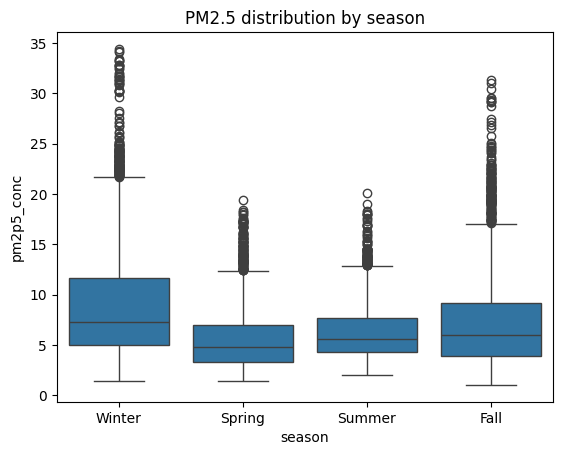

In [ ]:
sns.boxplot(x="season", y="pm2p5_conc", data=eur_df, order=["Winter","Spring","Summer","Fall"])
plt.title("PM2.5 distribution by season")
plt.show()

In [ ]:
#Really high or really low values in pollutants are normal, as the world encounters climate events that are out of the ordinary
#and doesn't necesarily mean there is an error in the dataset
#However we want to see how much do these outliers affect our data
#We use a log transform function to cap spikes in the data
numeric_cols = ['co_conc','no2_conc','o3_conc','pm10_conc','pm2p5_conc']

eur_df_log = eur_df.copy()
for col in numeric_cols:
    eur_df_log[col] = np.log1p(eur_df[col])

eur_df_log.describe()




level     latitude    longitude      co_conc     no2_conc  \
count  9504.000000  9504.000000  9504.000000  9504.000000  9504.000000   
mean     25.000000    48.850002     2.300000     5.167670     2.357213   
std      25.001316     0.081702     0.111807     0.236804     0.602993   
min       0.000000    48.750000     2.150000     4.598429     0.770207   
25%       0.000000    48.750000     2.225000     5.016917     1.926857   
50%      25.000000    48.849998     2.300000     5.138730     2.320485   
75%      50.000000    48.950001     2.375000     5.272207     2.779843   
max      50.000000    48.950001     2.450000     6.150422     4.161010   

           o3_conc    pm10_conc   pm2p5_conc    hour        month          day  
count  9504.000000  9504.000000  9504.000000  9504.0  9504.000000  9504.000000  
mean      4.117808     2.428673     1.992184    15.0     6.926768    15.742424  
std       0.481182     0.452340     0.493412     0.0     3.625605     8.808708  
min       1.020291     1.007607     0.712769    15.0     1.000000     1.000000  
25%       3.936890     2.120905     1.624119    15.0     4.000000     8.000000  
50%       4.229693     2.415648     1.936178    15.0     7.000000    16.000000  
75%       4.437238     2.694892     2.289862    15.0    10.000000    23.000000  
max       5.124398     3.891110     3.566714    15.0    12.000000    31.000000

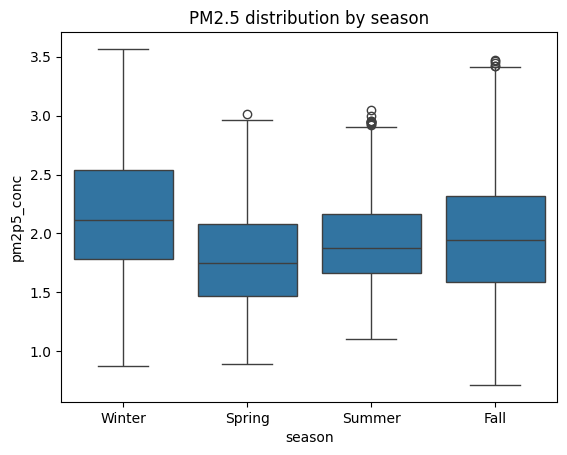

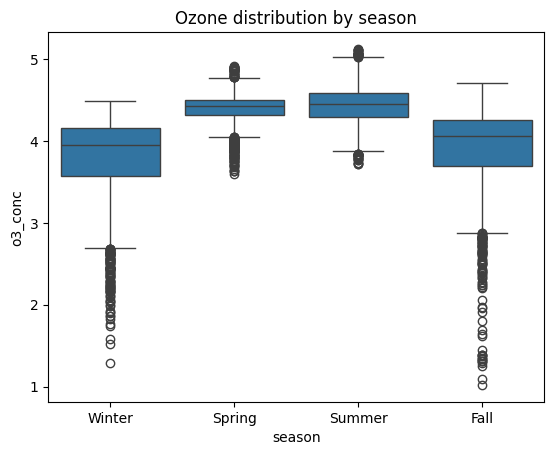

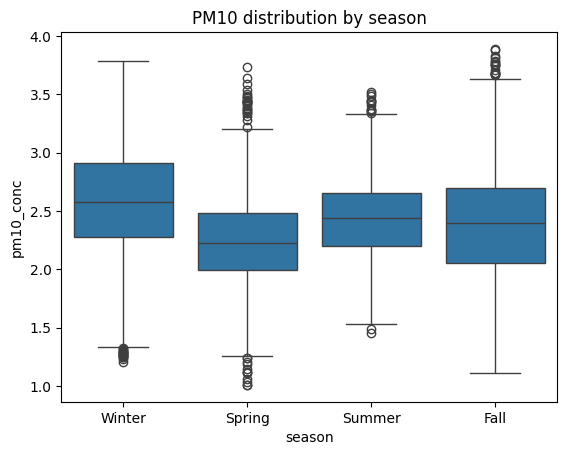

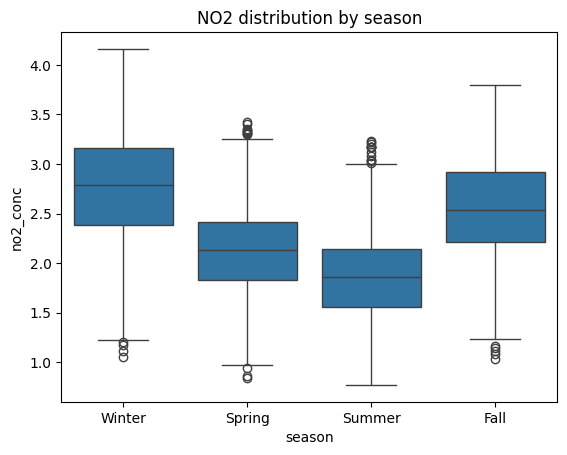

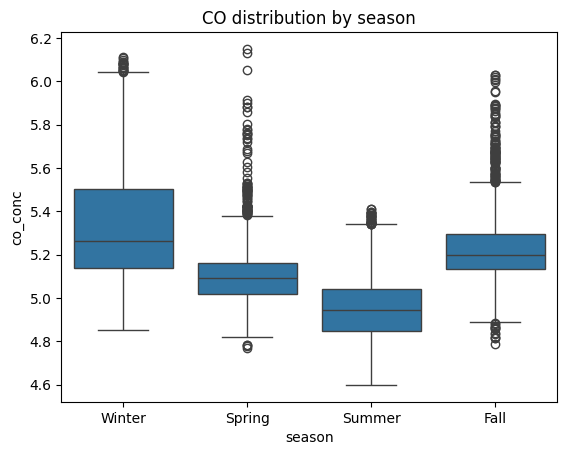

In [ ]:
#after the log function our values far from the mean and low/high quartile are still pretty close to the mean
sns.boxplot(x="season", y="pm2p5_conc", data=eur_df_log, order=["Winter","Spring","Summer","Fall"])
plt.title("PM2.5 distribution by season")
plt.show()

sns.boxplot(x="season", y="o3_conc", data=eur_df_log, order=["Winter","Spring","Summer","Fall"])
plt.title("Ozone distribution by season")
plt.show()

sns.boxplot(x="season", y="pm10_conc", data=eur_df_log, order=["Winter","Spring","Summer","Fall"])
plt.title("PM10 distribution by season")
plt.show()

sns.boxplot(x="season", y="no2_conc", data=eur_df_log, order=["Winter","Spring","Summer","Fall"])
plt.title("NO2 distribution by season")
plt.show()

sns.boxplot(x="season", y="co_conc", data=eur_df_log, order=["Winter","Spring","Summer","Fall"])
plt.title("CO distribution by season")
plt.show()

pm2p5_conc    1.000000
pm10_conc     0.923705
co_conc       0.714075
no2_conc      0.577626
latitude      0.073248
level         0.000060
longitude    -0.003418
o3_conc      -0.376928
Name: pm2p5_conc, dtype: float64


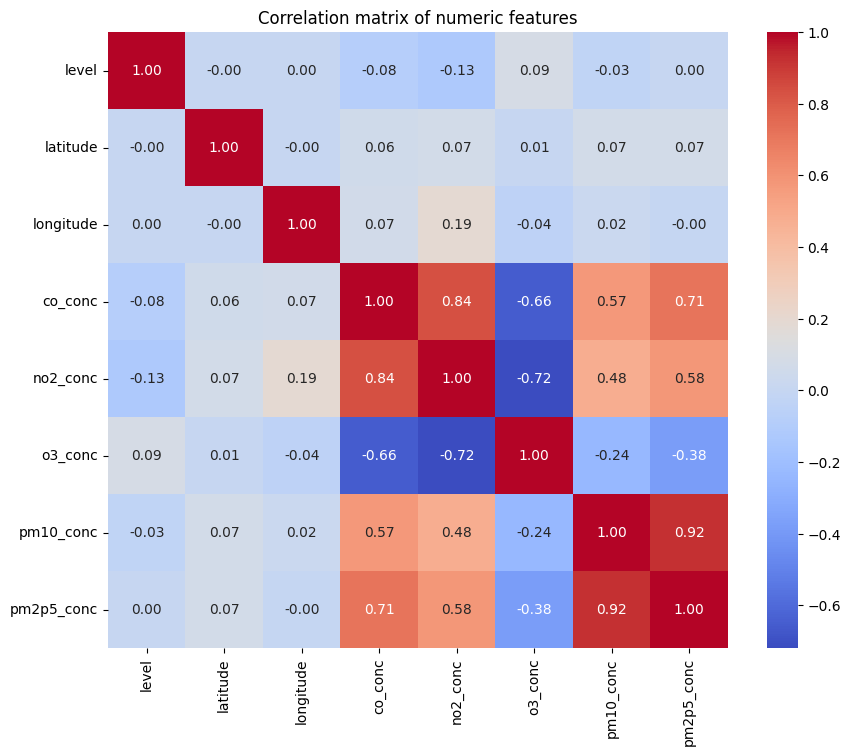

In [ ]:
numeric_cols = ["level", "latitude", "longitude", "co_conc", "no2_conc", "o3_conc", "pm10_conc", "pm2p5_conc"]
corr_matrix = eur_df[numeric_cols].corr()
print(corr_matrix["pm2p5_conc"].sort_values(ascending=False))

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix of numeric features")
plt.show()

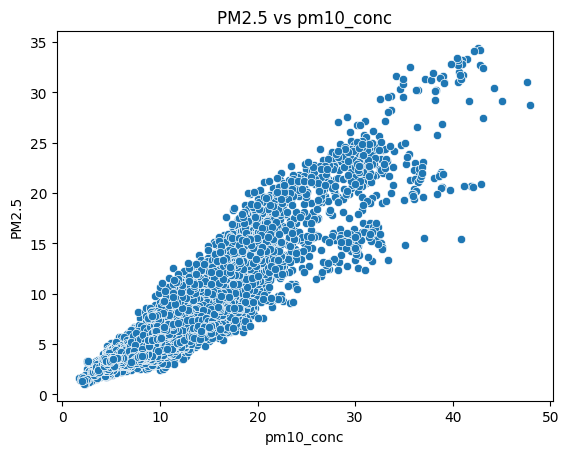

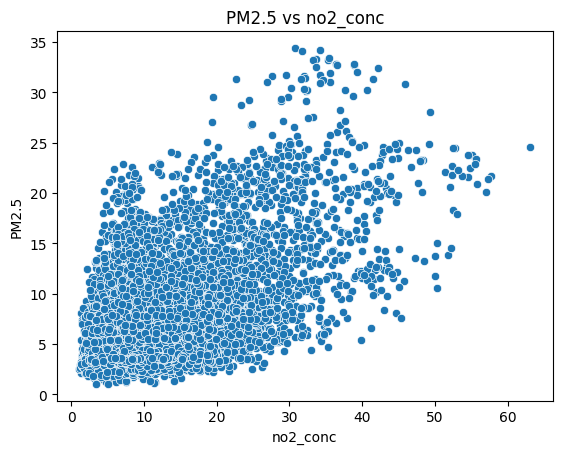

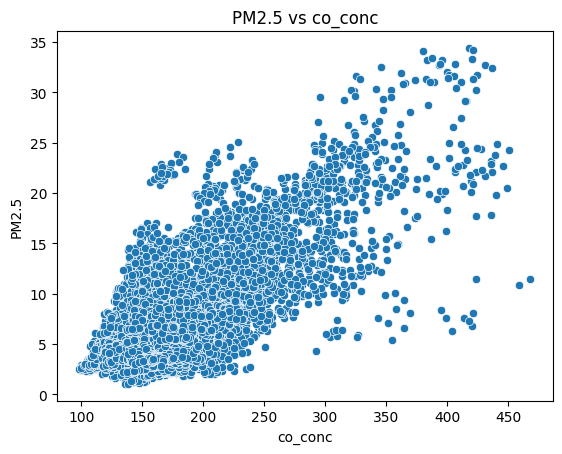

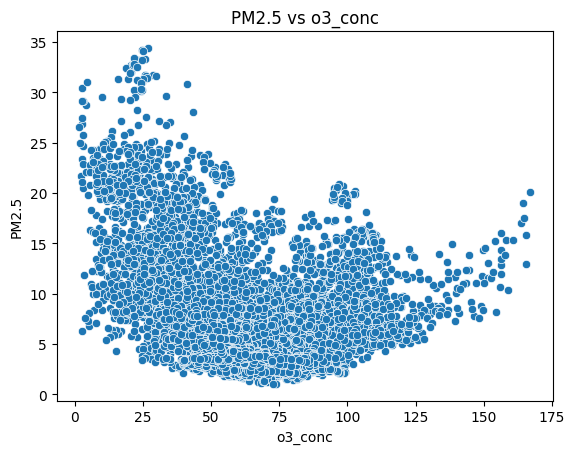

In [ ]:
#From correlation matrix we select the top features:

top_features = ["pm10_conc", "no2_conc", "co_conc", "o3_conc"]

for feature in top_features:
    sns.scatterplot(x=eur_df[feature], y=eur_df["pm2p5_conc"])
    plt.title(f"PM2.5 vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("PM2.5")
    plt.show()

In [ ]:
#One Hot Encoding
season_encoded = pd.get_dummies(eur_df["season"], prefix="season")
eur_df_encoded = pd.concat([eur_df, season_encoded], axis=1)
eur_df_encoded = eur_df_encoded.drop("season", axis=1)
print(eur_df_encoded.head())

   level   latitude  longitude     co_conc   no2_conc    o3_conc  pm10_conc  \
0    0.0  48.950001       2.15  253.677200  17.336933  37.339615  15.647315   
1    0.0  48.950001       2.25  276.141144  22.783443  33.625061  20.941568   
2    0.0  48.950001       2.35  286.583740  24.227728  30.771637  22.178879   
3    0.0  48.950001       2.45  283.718262  25.278826  27.562399  21.840717   
4    0.0  48.849998       2.15  250.339340  17.382927  37.635048  13.722682   

   pm2p5_conc  hour  month  day  season_Fall  season_Spring  season_Summer  \
0   15.114750    15     12    2        False          False          False   
1   17.069765    15     12    2        False          False          False   
2   17.768656    15     12    2        False          False          False   
3   18.636398    15     12    2        False          False          False   
4   10.638963    15     12    2        False          False          False   

   season_Winter  
0           True  
1           True  

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
season_ohe = encoder.fit_transform(eur_df[["season"]])
season_ohe_df = pd.DataFrame(season_ohe, columns=encoder.get_feature_names_out(["season"]))
eur_df_encoded = pd.concat([eur_df, season_ohe_df], axis=1)
eur_df_encoded = eur_df_encoded.drop("season", axis=1)

In [ ]:
eur_df_encoded.head()

level   latitude  longitude     co_conc   no2_conc    o3_conc  pm10_conc  \
0    0.0  48.950001       2.15  253.677200  17.336933  37.339615  15.647315   
1    0.0  48.950001       2.25  276.141144  22.783443  33.625061  20.941568   
2    0.0  48.950001       2.35  286.583740  24.227728  30.771637  22.178879   
3    0.0  48.950001       2.45  283.718262  25.278826  27.562399  21.840717   
4    0.0  48.849998       2.15  250.339340  17.382927  37.635048  13.722682   

   pm2p5_conc  hour  month  day  season_Fall  season_Spring  season_Summer  \
0   15.114750    15     12    2          0.0            0.0            0.0   
1   17.069765    15     12    2          0.0            0.0            0.0   
2   17.768656    15     12    2          0.0            0.0            0.0   
3   18.636398    15     12    2          0.0            0.0            0.0   
4   10.638963    15     12    2          0.0            0.0            0.0   

   season_Winter  
0            1.0  
1            1.0  
2            1.0  
3            1.0  
4            1.0

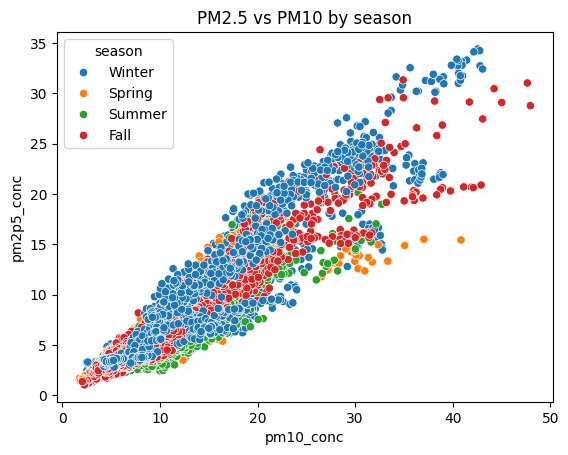

In [ ]:
sns.scatterplot(x="pm10_conc", y="pm2p5_conc", hue="season", data=eur_df) #not using encoded dataset, just so we can differentiate between values in season column
plt.title("PM2.5 vs PM10 by season")
plt.show()

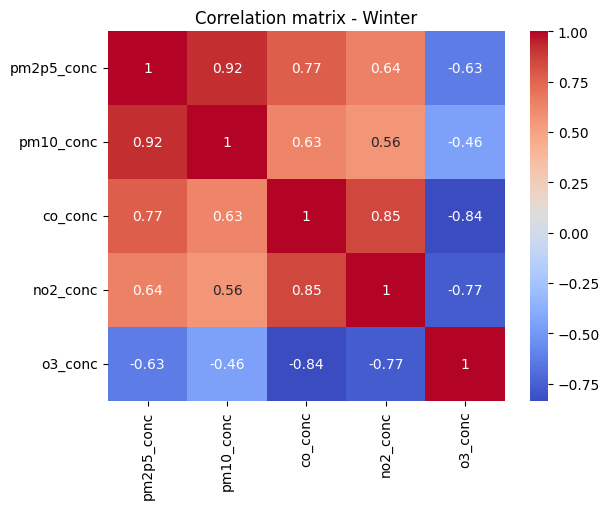

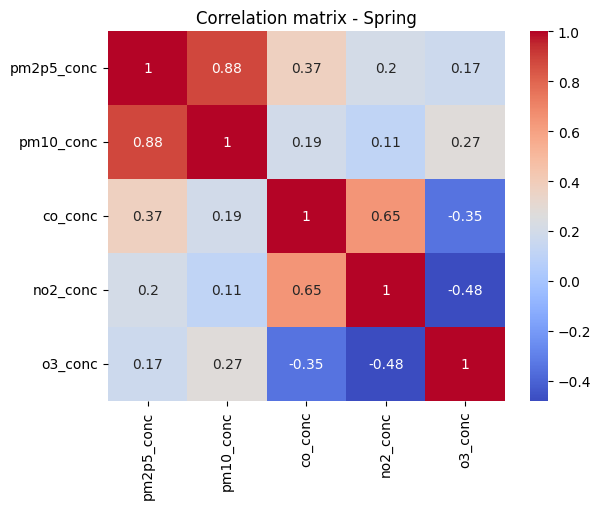

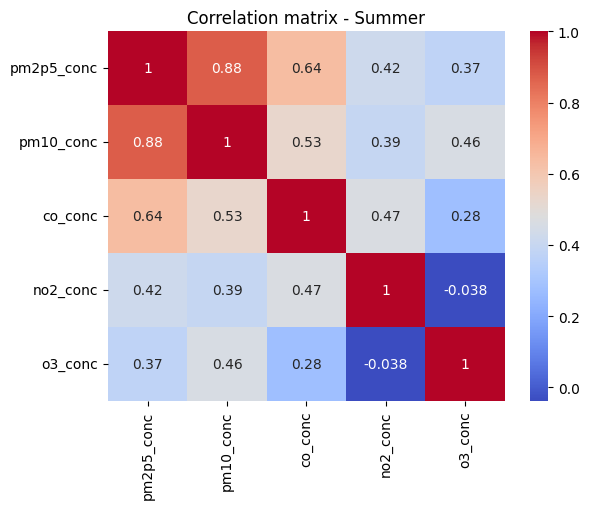

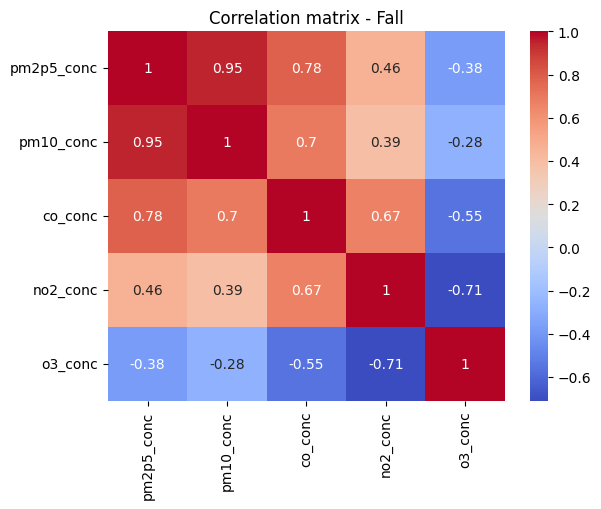

In [ ]:
for s in ["Winter", "Spring", "Summer", "Fall"]:
    subset = eur_df[eur_df["season"]==s]
    sns.heatmap(subset[["pm2p5_conc","pm10_conc","co_conc","no2_conc","o3_conc"]].corr(), annot=True, cmap="coolwarm")
    plt.title(f"Correlation matrix - {s}")
    plt.show()

## Modeling

In [ ]:
eur_df_encoded.columns

Index(['level', 'latitude', 'longitude', 'co_conc', 'no2_conc', 'o3_conc',
       'pm10_conc', 'pm2p5_conc', 'hour', 'month', 'day', 'season_Fall',
       'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object')

In [ ]:
'''X = eur_df_encoded[['co_conc', 'no2_conc', 'o3_conc', 'pm10_conc',
            'latitude', 'longitude', 'level',
            'month', 'day',
            'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter']]'''

X = eur_df_encoded[['co_conc', 'no2_conc', 'o3_conc', 'pm10_conc',
            'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter']]

y = eur_df_encoded['pm2p5_conc']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
#Linear Regression given linear correlations between contaminants
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("R2", r2_score(y_test, y_pred_lr))
print("Mean Absolute Error", mean_absolute_error(y_test, y_pred_lr))

R2 0.9113421356653095
Mean Absolute Error 1.1264485666576391


In [ ]:
#Because of MAPE values, we think that Linear regression might not be the move for this particular dataset or we may have to look back into our features
#Gradient Boosting
gbr= GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=4,
    subsample = 0.8,
    random_state = 42
)

gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

print("R2", r2_score(y_test, y_pred_gbr))
print("Mean Absolute Error", mean_absolute_error(y_test, y_pred_gbr))



R2 0.9454450646359649
Mean Absolute Error 0.8669900694080932


In [ ]:
print("Train R2", r2_score(y_train, gbr.predict(X_train)))
print("Test R2", r2_score(y_test, y_pred_gbr))
#Although the R2 value is high, we guarantee that the model is not overfitting by checking
#that both test and train splits are predicted similarly
#With this values we confirm that the model is not just memorizing the training dataset

Train R2 0.9590165340036327
Test R2 0.9454450646359649


In [ ]:
nmae =  mean_absolute_error(y_test, y_pred_gbr) / y_test.mean()
print("NMAE:", nmae)
#normalized mean squared error, especially useful when the scale of the data varies

NMAE: 0.11615729


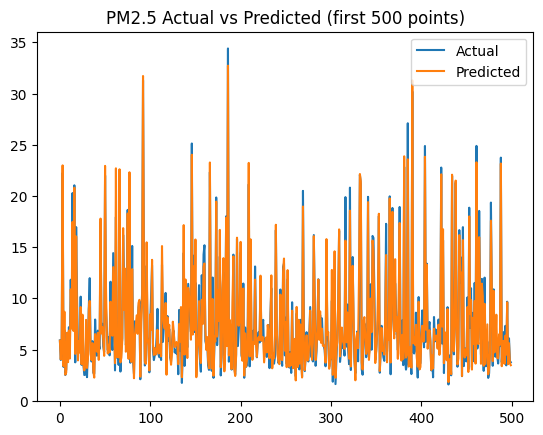

In [ ]:
plt.plot(y_test.values[:500], label='Actual')
plt.plot(y_pred_gbr[:500], label='Predicted')
plt.legend()
plt.title("PM2.5 Actual vs Predicted (first 500 points)")
plt.show()

Text(0.5, 1.0, 'Residual Distribution')

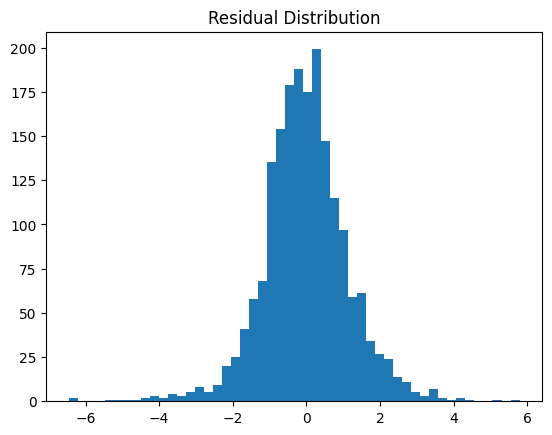

In [ ]:
residuals = y_test - y_pred_gbr
plt.hist(residuals, bins=50)
plt.title("Residual Distribution")


# Compare

In [ ]:
print(full_all.columns)
print(df_nd_air_quality.columns)
print(eur_df_encoded.columns)

Index(['Geo Place Name', 'O3 (ppb)', 'PM25 (mcg/m3)', 'NO2 (ppb)',
       'Vehicle Miles', 'Population_2020', 'ACRES_x', 'ACRES_y', 'city'],
      dtype='object')
Index(['day', 'Month', 'Year', 'Holidays_Count', 'Days', 'PM25 (mcg/m3)',
       'PM10', 'NO2 (ppb)', 'SO2', 'CO', 'O3 (ppb)', 'AQI', 'Date_full'],
      dtype='object')
Index(['level', 'latitude', 'longitude', 'co_conc', 'NO2 (ppb)', 'O3 (ppb)',
       'pm10_conc', 'PM25 (mcg/m3)', 'hour', 'month', 'day', 'season_Fall',
       'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object')


In [ ]:
eur_df_encoded = eur_df_encoded.rename(columns={'pm2p5_conc': 'PM25 (mcg/m3)', 'o3_conc': 'O3 (ppb)',
                        'no2_conc': 'NO2 (ppb)'})
df_nd_air_quality = df_nd_air_quality.rename(columns={'PM2.5': 'PM25 (mcg/m3)', 'Ozone': 'O3 (ppb)',
                        'NO2': 'NO2 (ppb)'})

columns_to_keep = ['PM25 (mcg/m3)', 'O3 (ppb)', 'NO2 (ppb)']





In [ ]:

full_all.head(15)

Geo Place Name   O3 (ppb)  PM25 (mcg/m3)  NO2 (ppb)  Vehicle Miles  \
0          Bronx  51.474209      28.580358  19.433997      38.438102   
1       Brooklyn  34.684600      19.952117  19.434271      39.258911   
2      Manhattan  34.537623      23.326942  25.428518      77.017269   
3         Queens  26.999647      15.575773  18.383770      37.084015   
4  Staten Island  26.561982      15.894650  14.095057      14.617416   

   Population_2020      ACRES_x      ACRES_y city  
0          1477476  3376.277366  3376.277366  NYC  
1          2736074  4861.818000  4861.818000  NYC  
2          1685657  2874.337000  2874.337000  NYC  
3          2409236  7740.171387  7740.171387  NYC  
4           495747  7716.890136  7716.890136  NYC

In [ ]:
eur_air = eur_df_encoded[columns_to_keep].copy()
nd_air = df_nd_air_quality[columns_to_keep].copy()
nyc_air = full_all[columns_to_keep].copy()

In [ ]:
nyc_air["city"] = "NYC"
eur_air["city"] = "Paris"
nd_air["city"] = "New Delhi"

In [ ]:
nyc_air.head(15)


PM25 (mcg/m3)   O3 (ppb)  NO2 (ppb) city
0      28.580358  51.474209  19.433997  NYC
1      19.952117  34.684600  19.434271  NYC
2      23.326942  34.537623  25.428518  NYC
3      15.575773  26.999647  18.383770  NYC
4      15.894650  26.561982  14.095057  NYC

In [ ]:
eur_air.head(15)

PM25 (mcg/m3)   O3 (ppb)  NO2 (ppb)   city
0       15.114750  37.339615  17.336933  Paris
1       17.069765  33.625061  22.783443  Paris
2       17.768656  30.771637  24.227728  Paris
3       18.636398  27.562399  25.278826  Paris
4       10.638963  37.635048  17.382927  Paris
5       16.567844  31.969469  24.829451  Paris
6       20.195223  27.551365  29.155788  Paris
7       22.170303  27.260866  28.582012  Paris
8       12.566608  40.351978  14.946362  Paris
9       13.526438  33.654884  20.243267  Paris
10      16.050470  29.919249  25.650482  Paris
11      20.810873  28.180935  30.639309  Paris
12      15.082551  38.623810  15.531557  Paris
13      17.727015  33.987038  20.777849  Paris
14      18.797325  32.422623  22.354828  Paris

In [ ]:
nd_air.head(15)

PM25 (mcg/m3)  O3 (ppb)  NO2 (ppb)       city
0          408.80     43.19     160.61  New Delhi
1          404.04     16.43      52.85  New Delhi
2          225.07     44.29     170.95  New Delhi
3           89.55     49.19     153.98  New Delhi
4           54.06     48.88     122.66  New Delhi
5          155.59     44.47     142.71  New Delhi
6          118.39     48.60      98.87  New Delhi
7          140.05     43.06     102.61  New Delhi
8          144.01     42.23     108.43  New Delhi
9          131.57     51.96      93.31  New Delhi
10         135.92     55.06     105.07  New Delhi
11         172.48     41.69     111.52  New Delhi
12         224.71     31.49     125.83  New Delhi
13         345.82     32.11     142.59  New Delhi
14         462.62     25.81     178.15  New Delhi

In [ ]:
combined = pd.concat([nyc_air, nd_air, eur_air], ignore_index=True)


In [ ]:
combined["city"].unique()

array(['NYC', 'New Delhi', 'Paris'], dtype=object)

In [ ]:
combined_encoded = pd.get_dummies(
    combined,
    columns=["city"]
)

In [ ]:
combined_encoded.head(15)

PM25 (mcg/m3)   O3 (ppb)   NO2 (ppb)  city_NYC  city_New Delhi  city_Paris
0       28.580358  51.474209   19.433997      True           False       False
1       19.952117  34.684600   19.434271      True           False       False
2       23.326942  34.537623   25.428518      True           False       False
3       15.575773  26.999647   18.383770      True           False       False
4       15.894650  26.561982   14.095057      True           False       False
5      408.800000  43.190000  160.610000     False            True       False
6      404.040000  16.430000   52.850000     False            True       False
7      225.070000  44.290000  170.950000     False            True       False
8       89.550000  49.190000  153.980000     False            True       False
9       54.060000  48.880000  122.660000     False            True       False
10     155.590000  44.470000  142.710000     False            True       False
11     118.390000  48.600000   98.870000     False            True       False
12     140.050000  43.060000  102.610000     False            True       False
13     144.010000  42.230000  108.430000     False            True       False
14     131.570000  51.960000   93.310000     False            True       False

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
season_ohe = encoder.fit_transform(combined[["city"]])
season_ohe_df = pd.DataFrame(season_ohe, columns=encoder.get_feature_names_out(["city"]))
combined_df_encoded = pd.concat([combined, season_ohe_df], axis=1)
combined_df_encoded = combined_df_encoded.drop("city", axis=1)

In [ ]:
combined_df_encoded

PM25 (mcg/m3)   O3 (ppb)  NO2 (ppb)  city_NYC  city_New Delhi  \
0          28.580358  51.474209  19.433997       1.0             0.0   
1          19.952117  34.684600  19.434271       1.0             0.0   
2          23.326942  34.537623  25.428518       1.0             0.0   
3          15.575773  26.999647  18.383770       1.0             0.0   
4          15.894650  26.561982  14.095057       1.0             0.0   
...              ...        ...        ...       ...             ...   
10965       7.965353  38.373402  20.225504       0.0             0.0   
10966       7.905327  54.228790   5.572606       0.0             0.0   
10967       7.842621  51.002247   8.926879       0.0             0.0   
10968       7.754166  43.692581  13.607622       0.0             0.0   
10969       7.755722  44.766529  12.478690       0.0             0.0   

       city_Paris  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           ...  
10965         1.0  
10966         1.0  
10967         1.0  
10968         1.0  
10969         1.0  

[10970 rows x 6 columns]

In [ ]:
X = combined_encoded.drop("PM25 (mcg/m3)", axis=1)
y = combined_encoded["PM25 (mcg/m3)"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42,
    stratify=combined["city"]
)

In [ ]:
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("R2", r2_score(y_test, y_pred_lr))
print("Mean Absolute Error", mean_absolute_error(y_test, y_pred_lr))

R2 0.4567576410490344
Mean Absolute Error 9.677397040708685
